In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn import model_selection
from sklearn import metrics
from sklearn import linear_model
from sklearn import kernel_ridge
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style = 'darkgrid',palette = 'dark')

In [29]:
data = pd.read_csv('data_final.csv')

0.1200000000000045
16870.98
185.08344835524014


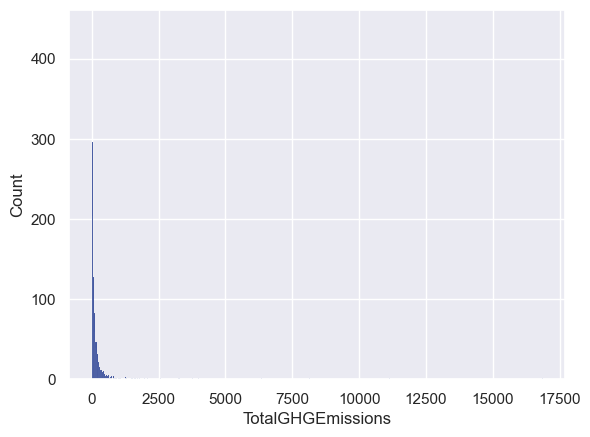

In [30]:
# Nous allons chercher à estimer les dégagement de gaz a effet de serre de nos nouveaux bâtiments.
# Commençons par regarder la distribution de notre variable sur les bâtiments connus.
sns.histplot(data['TotalGHGEmissions'])
print(min(data['TotalGHGEmissions']))
print(max(data['TotalGHGEmissions']))
print(data['TotalGHGEmissions'].mean())

In [31]:
# Regardons maintenant, au vue de la distribution en exponentielle décroissante, la distribution logarithmique de notr variable.
def passagelog(y, inverse):
    if inverse == True :
        y = FunctionTransformer(func = np.log).fit_transform(y)
    if inverse == False:
        y = FunctionTransformer(func = np.exp).fit_transform(y)
    return y

9.733350265139087
3.936093808016306


<AxesSubplot:xlabel='TotalGHGEmissions', ylabel='Count'>

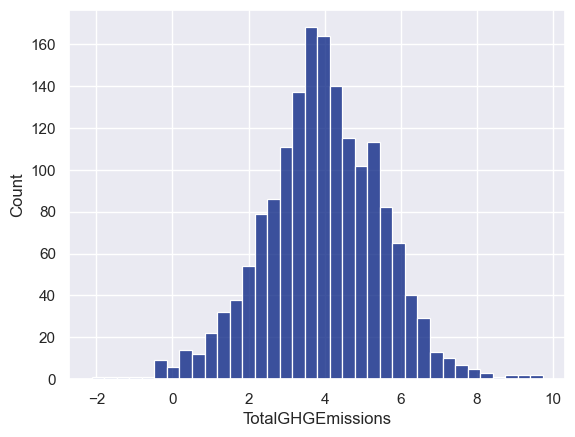

In [32]:
datalog = passagelog(data['TotalGHGEmissions'], True)
print(max(datalog))
print(datalog.mean())

sns.histplot(datalog)

In [33]:
# Nous allons définir l'erreur de préduction comme la mae (mean absolute error) que nous allons calculer en pourcentage de la 
# moyenne de notre prédiction (c'est plus clair d'avoir un score comme "en moyenne les valeurs sont écarté de leur valeur
# de 58% de la moyenne" plutôt que "En moyenne les valeurs sont écartés de 2,545.10^4 de leur valeur")
# On ajoute la possibilité de passer la variable cible sous forme logarithmique, du coup, on prends en compte en la repassant
# dans sa forme initiale lors du calcul de l'erreur.

def erreur_regression(ytest,ypred,log):
    if ytest.shape != ypred.shape:
        ypred = ypred.reshape(ypred.shape[0],)
    if log == True:
        erreur_absolue = (abs(passagelog(ypred,False)-ytest)*100/ytest.mean()).to_numpy()
    if log == False:
        erreur_absolue = (abs(ypred-ytest)*100/ytest.mean()).to_numpy()
    plot = sns.histplot(erreur_absolue)
    plot.set_title(f'Distribution de lerreur')
    plot.set_xlabel(f'Erreur moyenne comise sur les prédictions : \n erreur calculée : moyenne des valeurs absolue des écart de prédiction en pourcentage de la moyenne \n  |ypred - ytest|/ytest.mean en pourcent : {round(erreur_absolue.mean(),2)} %')
    plot.set_ylabel(f'Count \n taille de lechantillon : {ytest.shape[0]}')
    
    return plot
    

In [34]:
# Une seule valeur ne produira pas assez de renseignement pour décider si un modèle est bon ou pas. Ajoutons donc à notre 
# calcul d'erreur un graphique montrant l'évolution de celle ci quand on retire les pires prédictions une a une.
def evolution_erreur(ytest,ypred,log):
    evolution = []
    nb_valeur_virees = []
    if ytest.shape != ypred.shape:
        ypred = ypred.reshape(ypred.shape[0],)
    if log == True:
        erreur_absolue = (abs(passagelog(ypred,False)-ytest)*100/ytest.mean()).to_numpy()
    if log == False:
        erreur_absolue = (abs(ypred-ytest)*100/ytest.mean()).to_numpy()
    evolution.append(erreur_absolue.mean())
    nb_valeur_virees.append(0)
    for i in range(50):
        erreur_absolue = np.delete(erreur_absolue, erreur_absolue.argmax())
        evolution.append(erreur_absolue.mean())
        nb_valeur_virees.append(i+1)
    plot = sns.lineplot(x = nb_valeur_virees, y = evolution)
    plot.set_title("Evolution de l'erreur en fonction du nombre de pire prédiction déconsidérées")
    plot.set_xlabel("Nombre de prédiction retirées (on retire toujours la pire)")
    plot.set_ylabel("Erreur [ytest-ypred]/ytest.mean en %")
    return plot

In [35]:
def ensembles_indicateur_qualite_prediction(ytest,ypred,log):
    table = pd.DataFrame()
    if ytest.shape != ypred.shape:
        ypred = ypred.reshape(ypred.shape[0],)
    if log == True:
        ypred = passagelog(ypred,False)
        
    mae = mean_absolute_error(y_true = ytest, y_pred = ypred)
    mse = mean_squared_error(y_true = ytest, y_pred = ypred)
    sqrtmse = math.sqrt(mse)
    r2 = r2_score(y_true = ytest, y_pred = ypred)
    
    table['Mean_all_datas'] = [y.mean()]
    table['Mean_test_sample'] = [ytest.mean()]
    table['Mean_predictions_of_sample'] = [ypred.mean()]
    table['Mae'] = [mae]
    table['Mse'] = [mse]
    table['Mse_square_rooted'] = [sqrtmse]
    table['R2_score'] = [r2]
    table = table.T
    
    return table

In [36]:
# Nous allons regarder nos test linéaires "basique" pour avoir un premier indicateur pour pouvoir constater ensuite l'amélioration
# de nos prédiction. Nous prenons en compte la possibilité de passer la variable cible en son logarithme.

def test_lineaire(x,y,log,scaler):
    "test les valeurs X pour prédire y avec Ridge et Lasso. Normalisation = True / False selon qu'on standardise les données"

    alpha = np.logspace(-2,1,10)
    param={"alpha" : alpha }
    xtest_copy = xtest.copy()
    
    if scaler == True:
        x = centre_et_norme(x)
        xtest_copy = centre_et_norme(xtest_copy)
    
    lin = linear_model.LinearRegression()
    if log == True:
        lin.fit(x,passagelog(y,True))
    if log == False:
        lin.fit(x,y)
    if scaler == True:
        y_predict0 = lin.predict(xtest_copy)
    if scaler == False:
        y_predict0 = lin.predict(xtest)
        
    
    clf1 = model_selection.GridSearchCV(
        linear_model.Lasso(), 
        param,    
        cv=5,
        scoring = 'neg_mean_absolute_error')
    if log == True:
        clf1.fit(x,passagelog(y,True))
    if log == False:
        clf1.fit(x,y)
        
    if scaler:
        y_predict1 = clf1.predict(xtest_copy)
    else:
        y_predict1 = clf1.predict(xtest)
    
    
    
    clf2 = model_selection.GridSearchCV(
        linear_model.Ridge(), 
        param,    
        cv=5,
        scoring = 'neg_mean_absolute_error')
    if log == True:
        clf2.fit(x,passagelog(y,True))
    if log == False:
        clf2.fit(x,y)
    if scaler == True:
        y_predict2 = clf2.predict(xtest_copy)
    if scaler == False:
        y_predict2 = clf2.predict(xtest)
    
    print("Erreurs des modèle, de haut en bas : Regression linéaire, Regression Lasso et Regression Ridge")
    
    fig, ax = plt.subplots(ncols=2,figsize=(14, 5))
    plt.sca(ax[0])
    erreur_regression(ytest,y_predict0,log)
    plt.sca(ax[1])
    evolution_erreur(ytest,y_predict0,log)
    fig, ax = plt.subplots(ncols=2,figsize=(14, 5))
    plt.sca(ax[0])
    erreur_regression(ytest,y_predict1,log)
    plt.sca(ax[1])
    evolution_erreur(ytest,y_predict1,log)
    fig, ax = plt.subplots(ncols=2,figsize=(14, 5))
    plt.sca(ax[0])
    erreur_regression(ytest,y_predict2,log)
    plt.sca(ax[1])
    evolution_erreur(ytest,y_predict2,log)

In [37]:
# Testons l'amélioration en applicant la méthode du noyau par rapport aux simple regression linéaires.

def test_lineaire_kernel(x,y, kernel, log, scaler):
    alpha = np.logspace(-2,2,10)
    
    xtest_copy = xtest
    
    if scaler:
        x = centre_et_norme(x)
        xtest_copy = centre_et_norme(xtest_copy)
    
    if kernel == 'rbf':
        gamma = np.logspace(-3,1,7)
        param={"alpha" : alpha ,"gamma" : gamma, "kernel" : ['rbf']}
    if kernel == 'polynomial':
        param={"alpha" : alpha , "kernel" : ['polynomial'], 'degree' : [2,3,4]}
    clf1 = model_selection.GridSearchCV(
        kernel_ridge.KernelRidge(), 
        param,    
        cv=5,
        scoring = 'neg_mean_absolute_error')
    if log == True:
        clf1.fit(x,passagelog(y,True))
    if log == False:
        clf1.fit(x,y)
    y_predict1 = clf1.predict(xtest_copy)
    fig, ax = plt.subplots(ncols=2,figsize=(14, 5))
    plt.sca(ax[0])
    erreur_regression(ytest,y_predict1,log)
    plt.sca(ax[1])
    evolution_erreur(ytest,y_predict1,log)
    print(f'les meilleurs paramètres du modèle sont : {clf1.best_params_}')
    return ensembles_indicateur_qualite_prediction(ytest,y_predict1, log)
    

In [38]:
# Regardons maintenant le réseau de nerone. Il est assez complexe de trouver la bonne sétup pour produire de bonnes prédiction.
# Je n'ai pas beaucoup d'espoir en ce modèle, je ne l'ai pas poussé plus qu'avoir comme argument le nombre de couche de
# neurone de même taille a ajouter. En fait, je n'ai pas beaucoup d'enthousiasme car la prédiction finale restera une regression
# linéaire avec une méthode différente de calcul des coefficients.

def y_shape(y):
    if len(y.shape) == 1:
        return 1
    else:
        return y.shape[1]
    
def test_neurone(x,y, nbcouche,log, scaler):
    xtest_copy = xtest
    
    if scaler:
        x = centre_et_norme(x)
        xtest_copy = centre_et_norme(xtest_copy)
        
    model = Sequential()
    for i in range(nbcouche):
        model.add(Dense(input_dim = x.shape[1], units = y_shape(y), activation = 'linear'))
    model.compile(loss = 'MeanSquaredError', optimizer ='adam', metrics = ['accuracy'])
    if log == True:
        model.fit(x,passagelog(y,True),epochs=150,batch_size=20)
    if log == False :
        model.fit(x,y,epochs=150,batch_size=20)
    y_pred = model.predict(xtest_copy)
    fig, ax = plt.subplots(ncols=2,figsize=(14, 5))
    plt.sca(ax[0])
    erreur_regression(ytest,y_pred,log)
    plt.sca(ax[1])
    evolution_erreur(ytest,y_pred,log)
    return ensembles_indicateur_qualite_prediction(ytest,y_pred, log)

<AxesSubplot:>

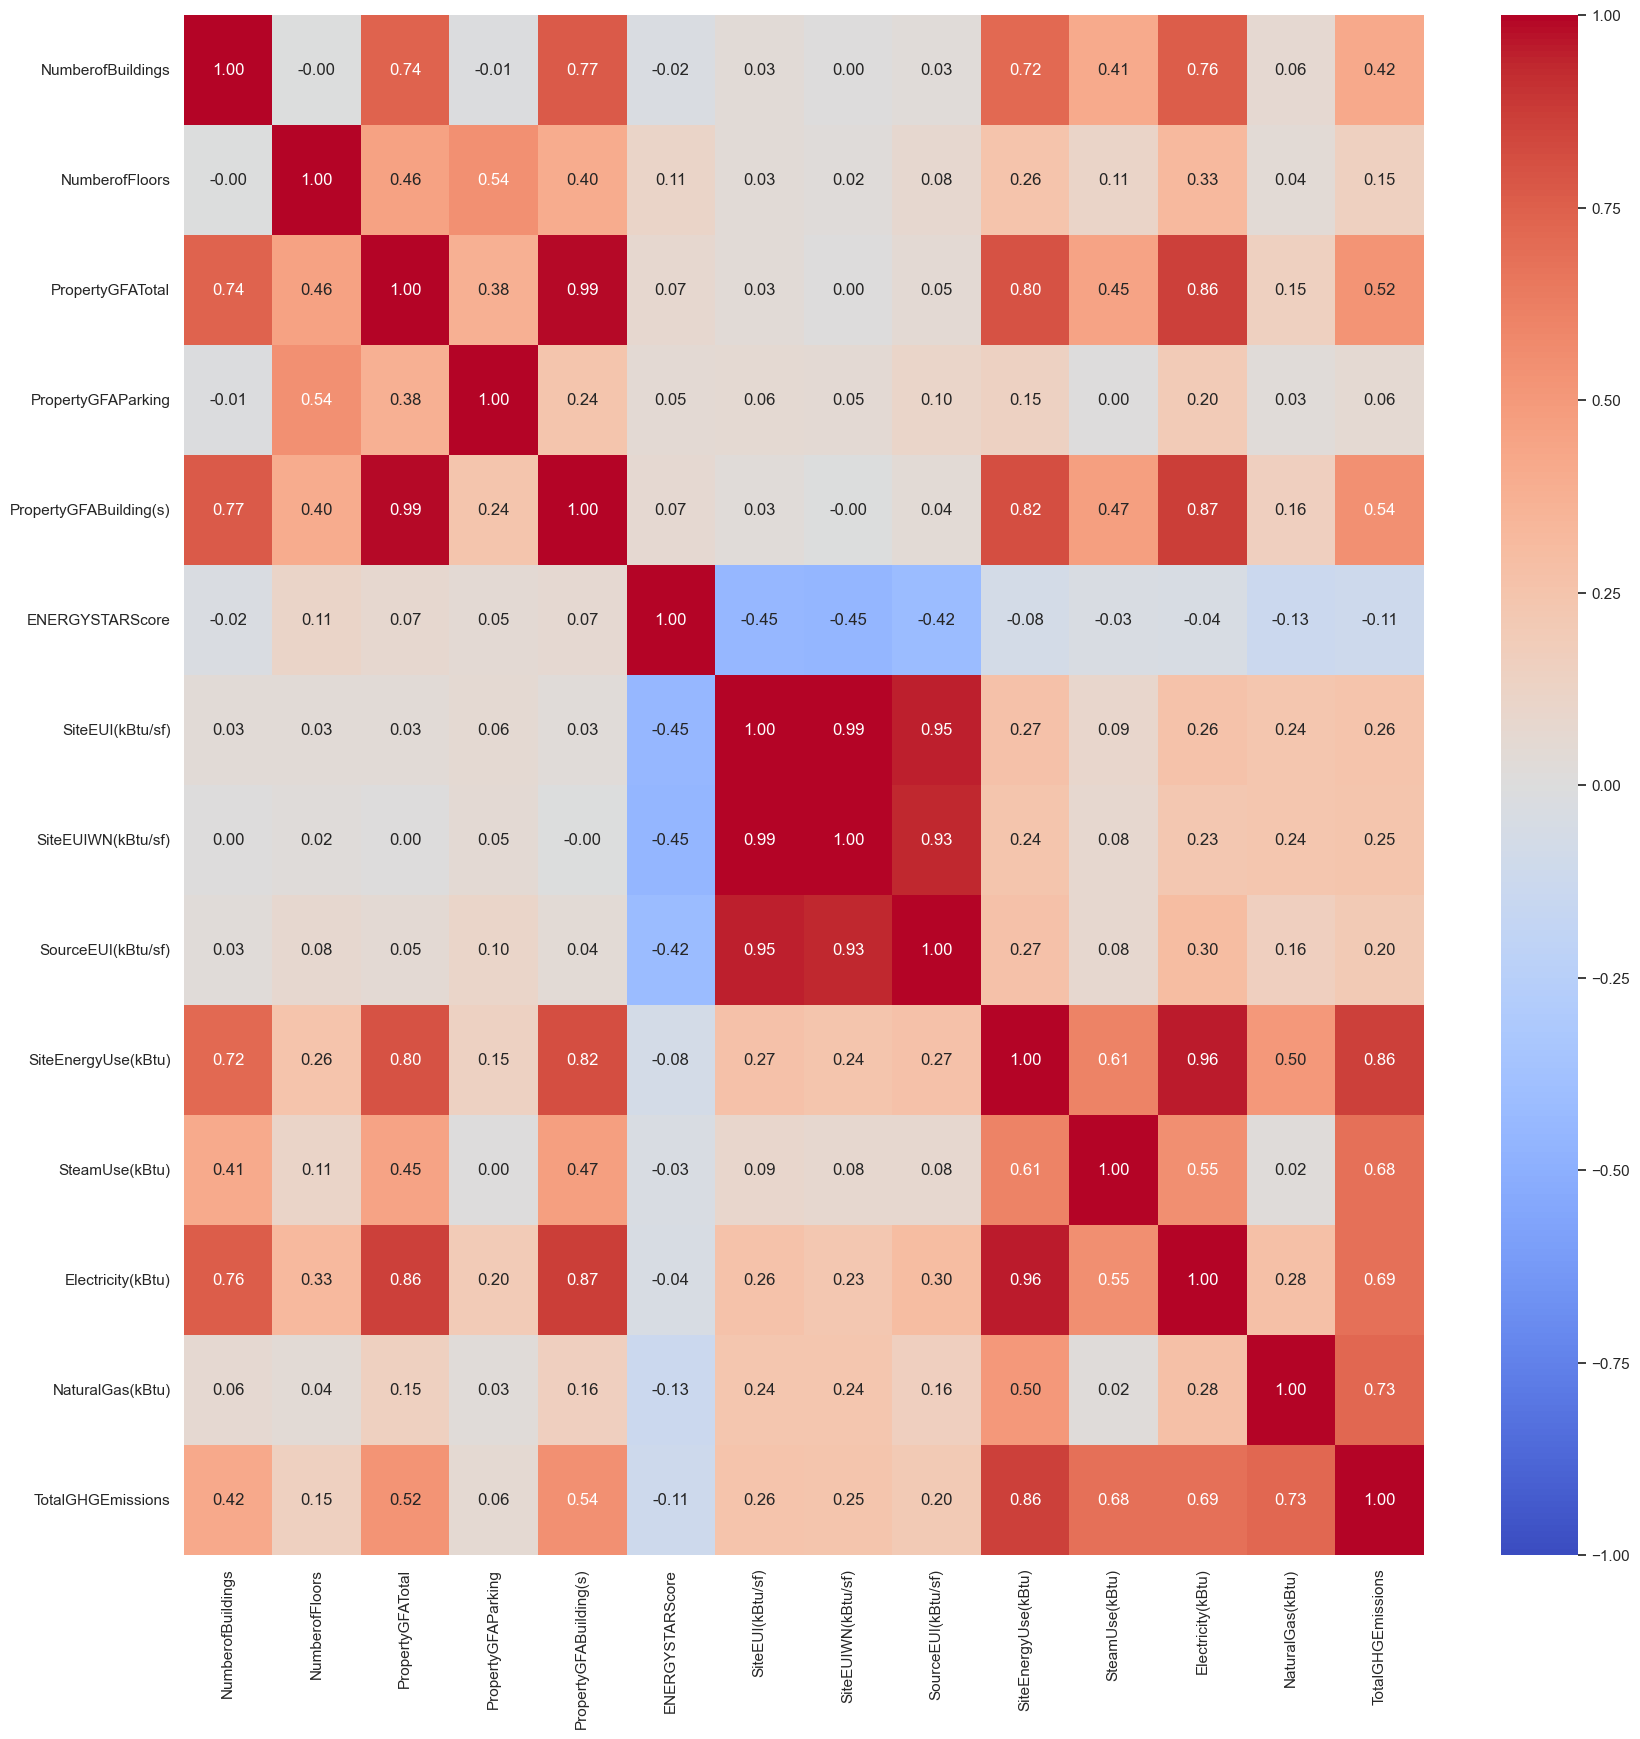

In [39]:
# Avant de définir les différentes features de mon vecteur de prédiction X, regardons les corrélations entre nos variables.

correlations = data[['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
 'PropertyGFAParking', 'PropertyGFABuilding(s)',
 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)',
 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)', 
 'NaturalGas(kBtu)', 'TotalGHGEmissions']].corr()

fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(correlations, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

In [40]:
# Choisissons en premier lieu de prendre les features suivantes. J'ai évité de prendre des variables trop corrélés entre elles
# Ou corrélés avec trop d'autres variables déjà présente. On ajoute le renseignement du lieu ou se trouve le batiment.
# On peut choisir de normaliser nos valeurs si besoin, et étudier la différence sur la prédiction (voir le power point final)

Liste_premier_model = ['PropertyGFABuilding(s)',
                       'NumberofBuildings',
                       'ENERGYSTARScore', 
                       'YearBuilt', 
                       'NumberofFloors',
                       "proportion steam (en %)",
                       "proportion electricity (en %)",
                       "proportion gas (en %)"]


Liste_premier_model.extend(list(data['Neighborhood'].unique()))
Liste_premier_model

['PropertyGFABuilding(s)',
 'NumberofBuildings',
 'ENERGYSTARScore',
 'YearBuilt',
 'NumberofFloors',
 'proportion steam (en %)',
 'proportion electricity (en %)',
 'proportion gas (en %)',
 'DOWNTOWN',
 'SOUTHEAST',
 'NORTHEAST',
 'EAST',
 'Central',
 'NORTH',
 'MAGNOLIA / QUEEN ANNE',
 'LAKE UNION',
 'GREATER DUWAMISH',
 'BALLARD',
 'NORTHWEST',
 'CENTRAL',
 'SOUTHWEST',
 'DELRIDGE',
 'Ballard',
 'North',
 'Delridge',
 'Northwest',
 'DELRIDGE NEIGHBORHOODS']

In [41]:
# Pour tout les modèle que l'on va tester, on va utiliser la même séparation de train / test, que l'on définis mainteant.

X = data[Liste_premier_model]
y = data['TotalGHGEmissions']
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(X, y, train_size=0.8)

In [42]:
# Créons une fonction de centrage réduction mais seulement appliquée à certaines colonnes de nos données.
# Détail important : on veut que le scaler soit fit sur X, de départ, pour éviter de fit sur xtrain puis sur xtest en changeant 
# les moyenne et écart type. Malheureusement, la fonction StandardScaler ne permet pas de fit sur un vecteur a 27 variable, 
# Puis d'être utilisé sur un vecteur ayant un nombre différent de variable. On va donc le faire à la main.

Liste_a_centrer_reduire = ['PropertyGFATotal','NumberofBuildings',
                           'ENERGYSTARScore', 'YearBuilt',
                           'proportion steam (en %)', 'proportion electricity (en %)',
                           'NumberofFloors', 'PropertyGFAParking',
                           'PropertyGFABuilding(s)', 'SiteEUI(kBtu/sf)',
                           'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)',
                           'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 
                           'Electricity(kBtu)', 'NaturalGas(kBtu)', 
                           'TotalGHGEmissions', 'proportion gas (en %)']


    
def centre_et_norme(x):
    colones_communes = [k for k in Liste_a_centrer_reduire if k in list(x.columns)]
    x_copy = x.copy(deep = True)
    for i in colones_communes:
        x_copy[i] = (x_copy[i]-X[i].mean())/X[i].std()
    return x_copy

Erreurs des modèle, de haut en bas : Regression linéaire, Regression Lasso et Regression Ridge


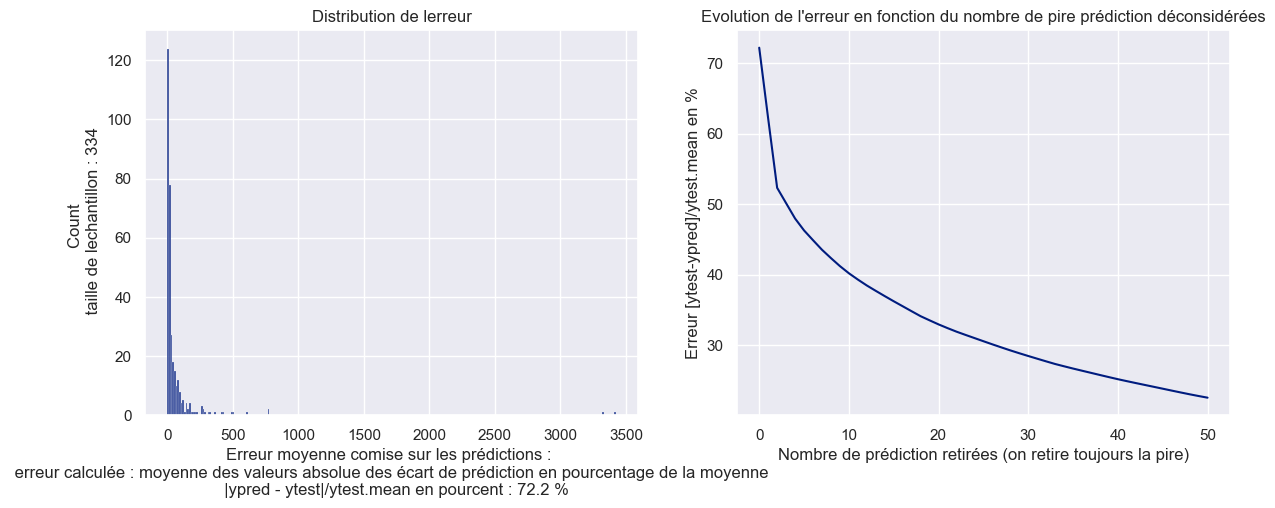

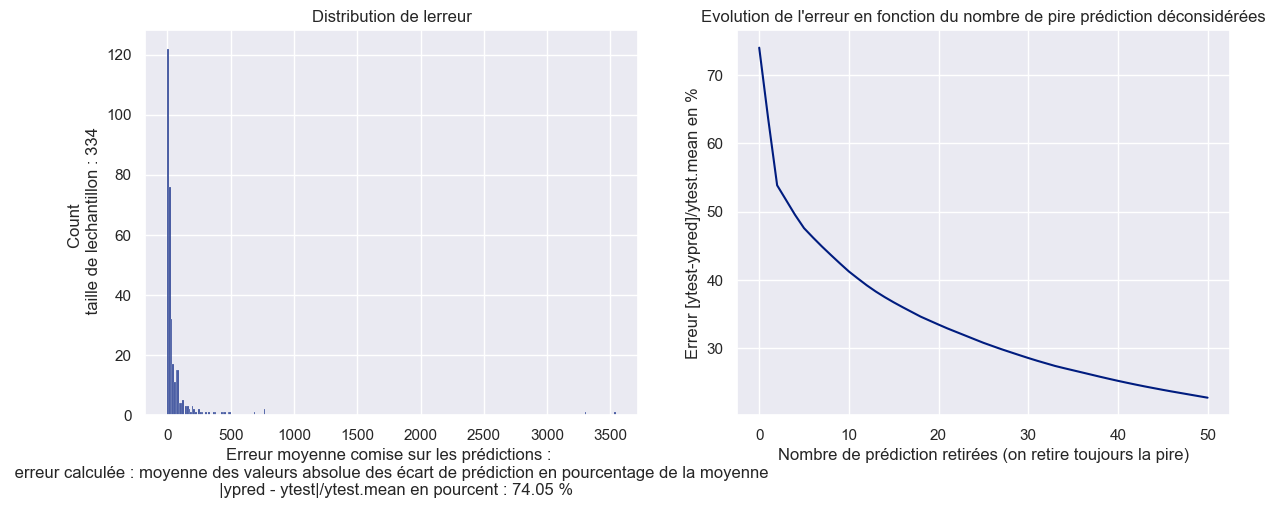

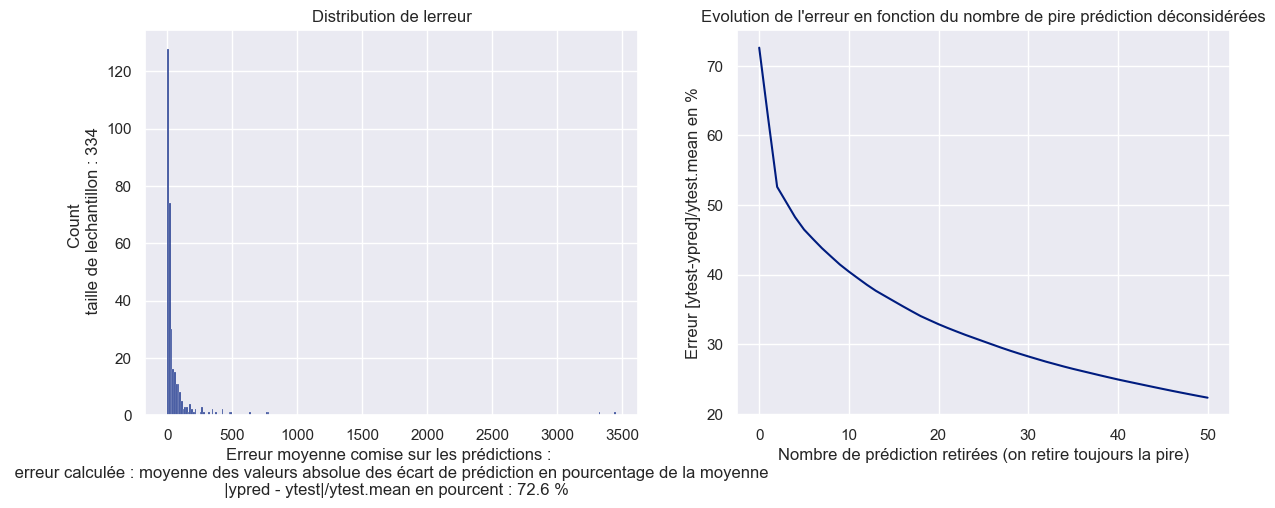

In [15]:
# test des 3 regression linéaires. Le premier True/False = passage au log, le second = scaler des données ou non.
test_lineaire(xtrain,ytrain, True, True)

Erreurs des modèle, de haut en bas : Regression linéaire, Regression Lasso et Regression Ridge


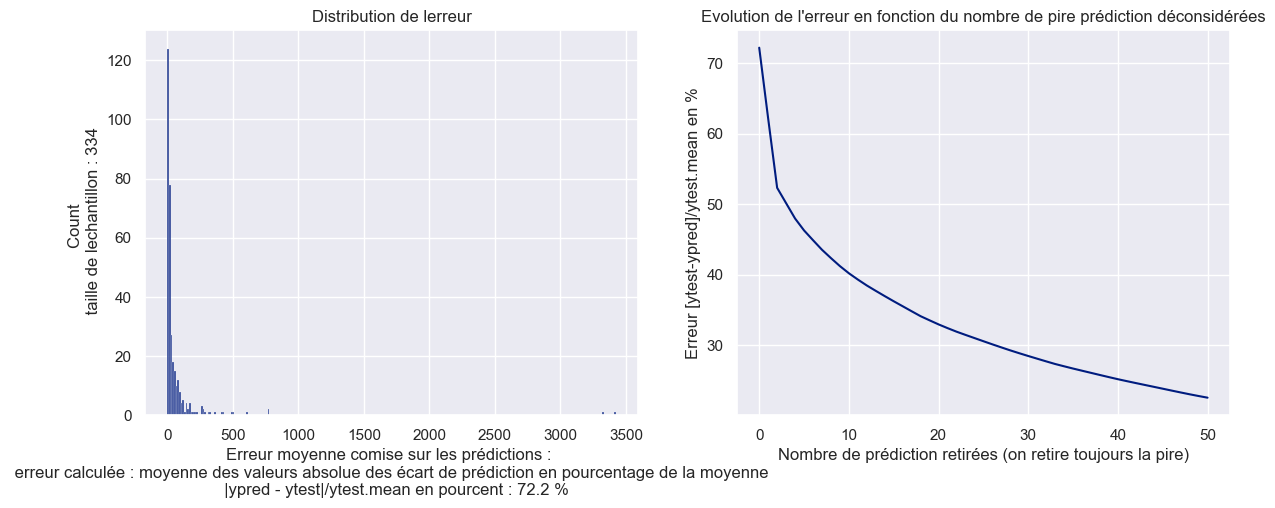

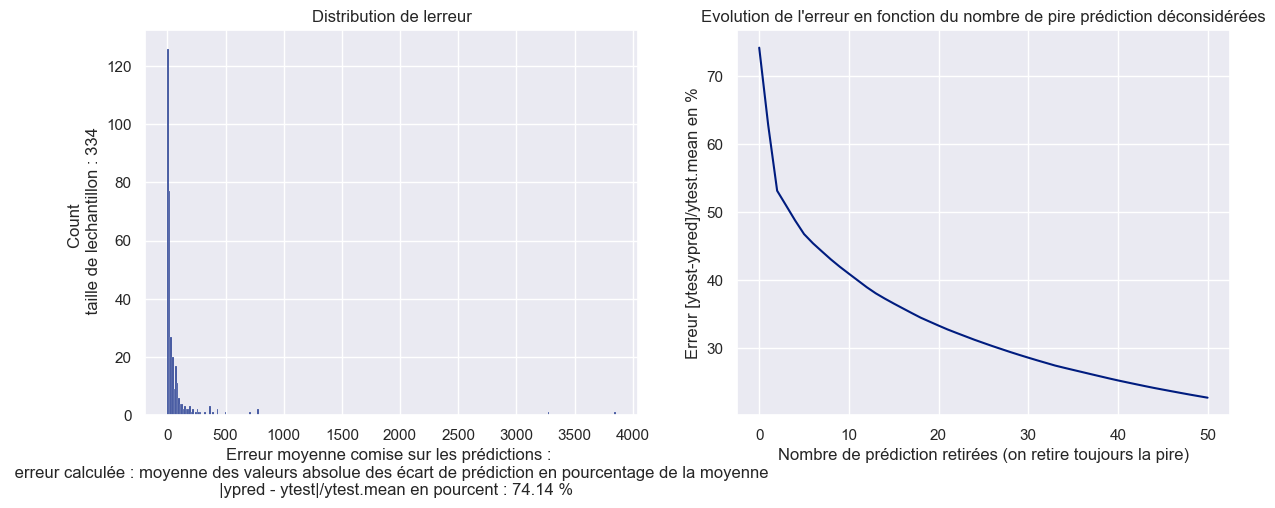

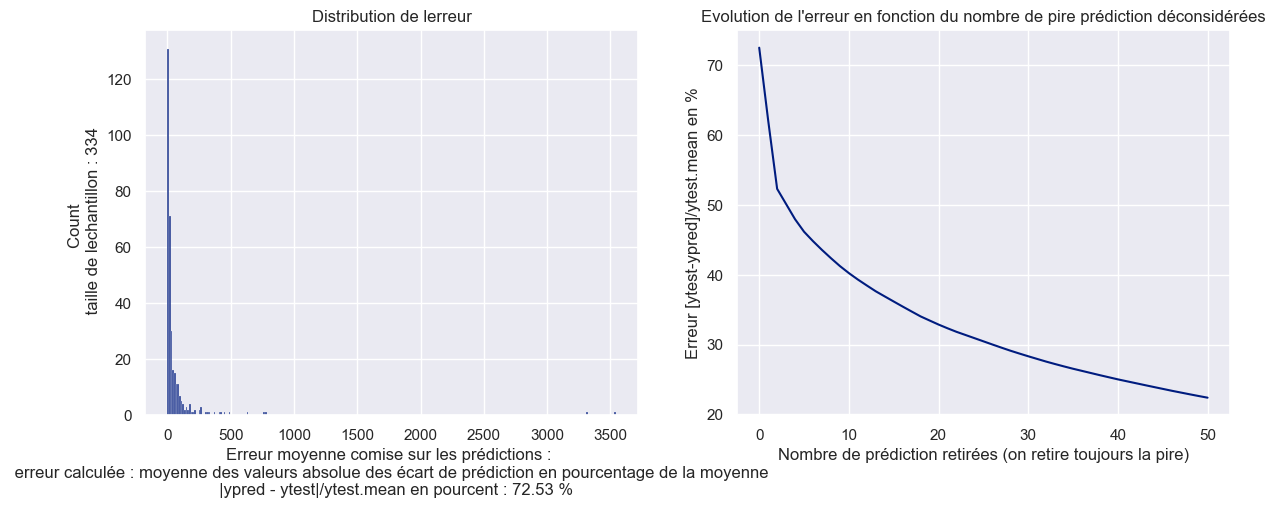

In [16]:
test_lineaire(xtrain,ytrain, True, False)

Erreurs des modèle, de haut en bas : Regression linéaire, Regression Lasso et Regression Ridge


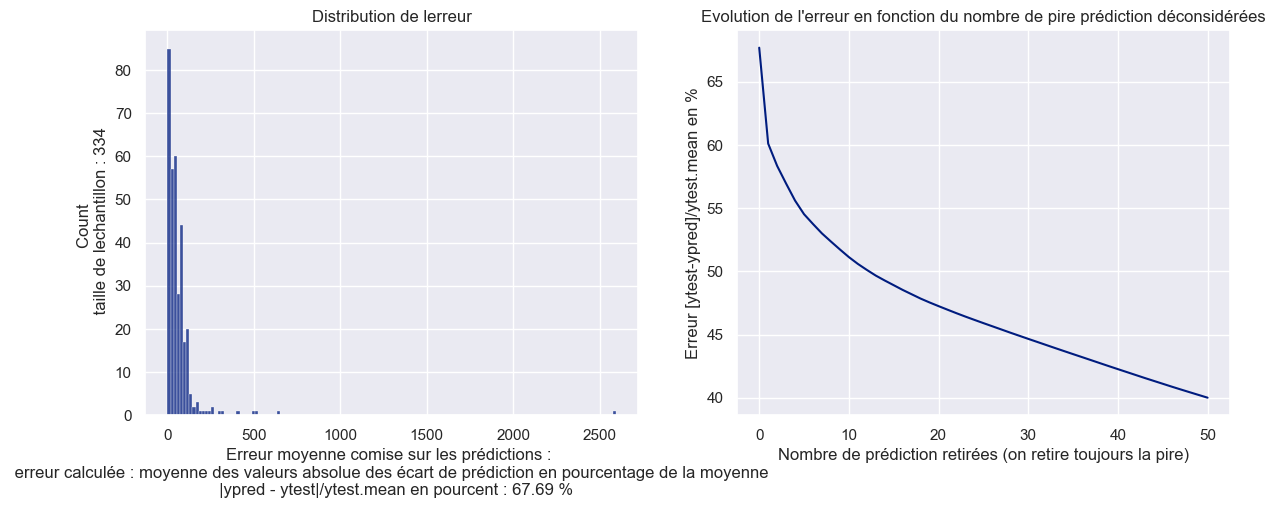

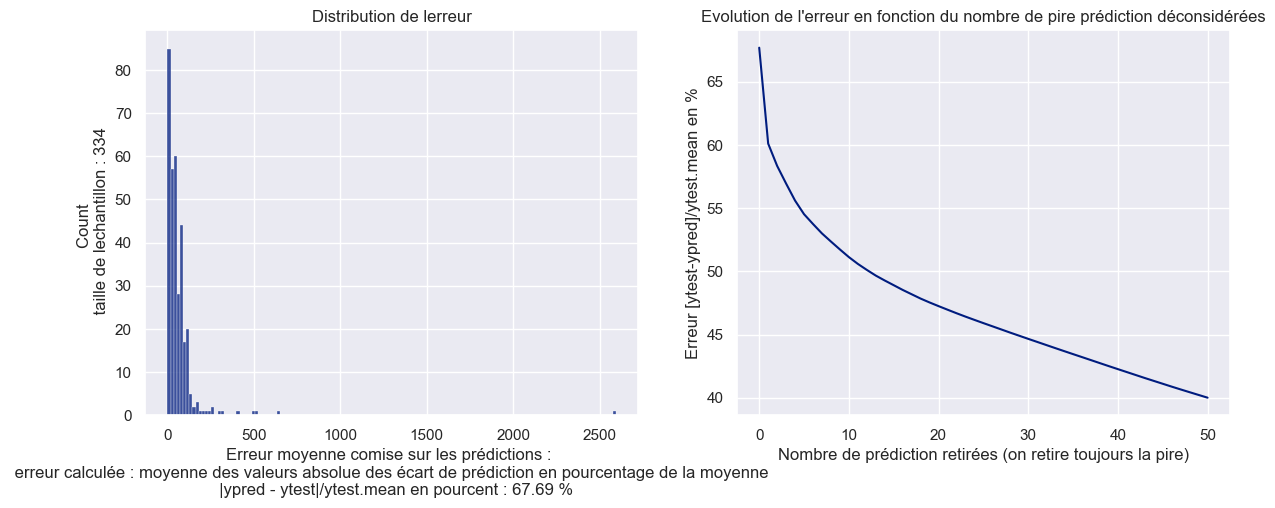

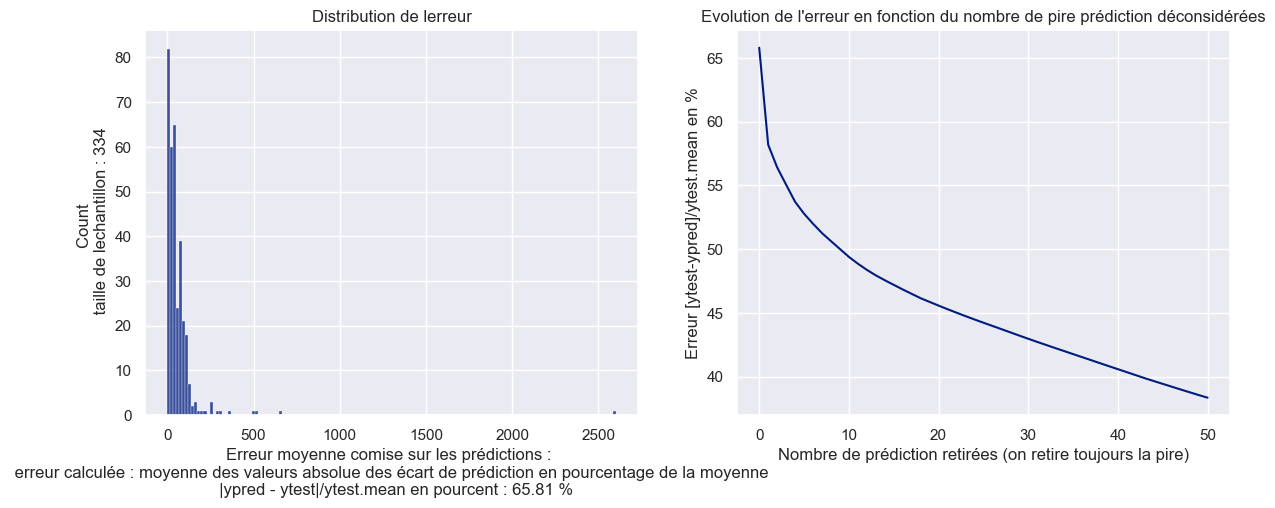

In [17]:
test_lineaire(xtrain,ytrain, False, True)

Erreurs des modèle, de haut en bas : Regression linéaire, Regression Lasso et Regression Ridge


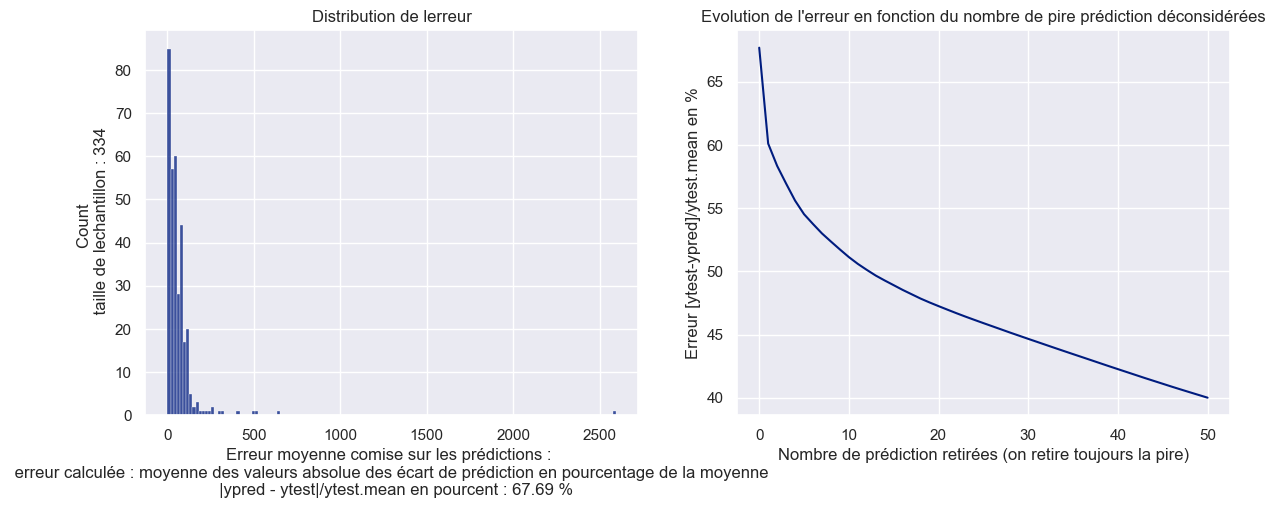

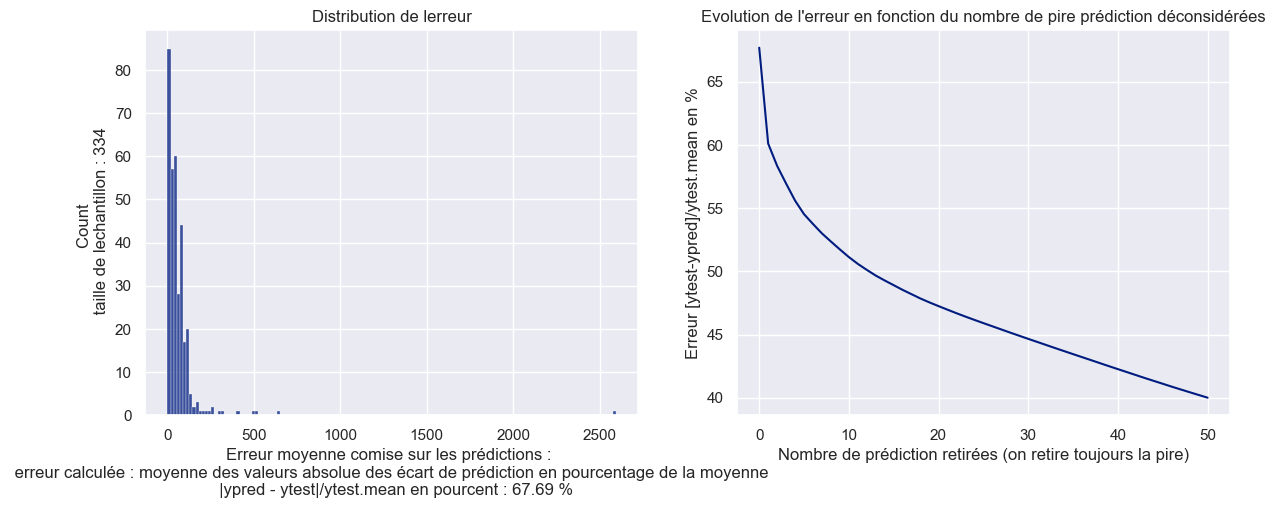

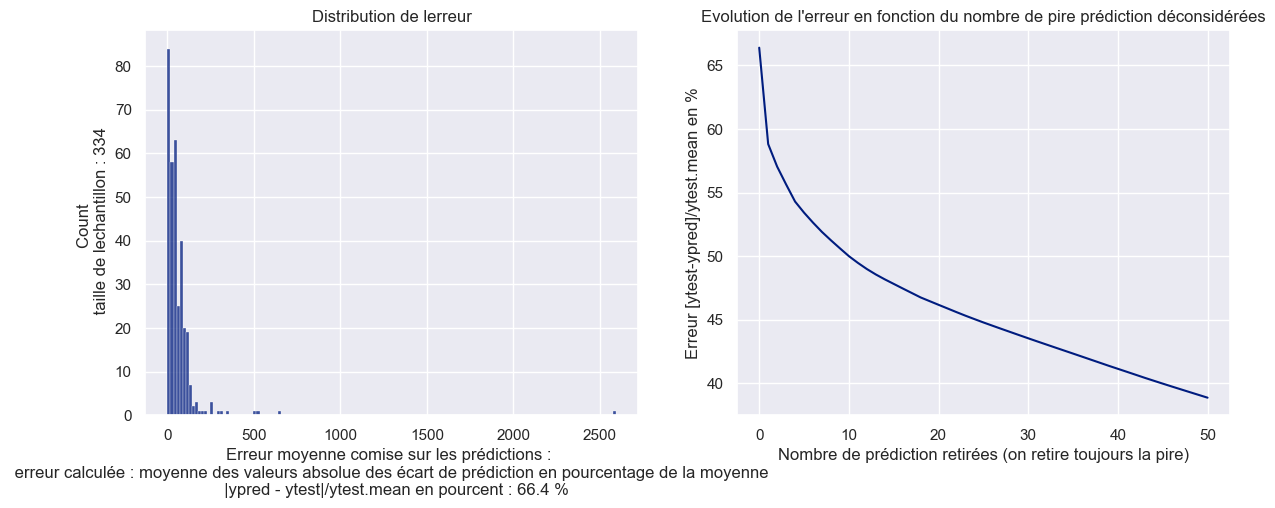

In [18]:
test_lineaire(xtrain,ytrain, False, False)

les meilleurs paramètres du modèle sont : {'alpha': 0.01, 'gamma': 0.021544346900318832, 'kernel': 'rbf'}


0
Mean_all_datas                 185.083448
Mean_test_sample               178.815841
Mean_predictions_of_sample     168.663979
Mae                             92.222932
Mse                         112042.311299
Mse_square_rooted              334.727219
R2_score                         0.489751

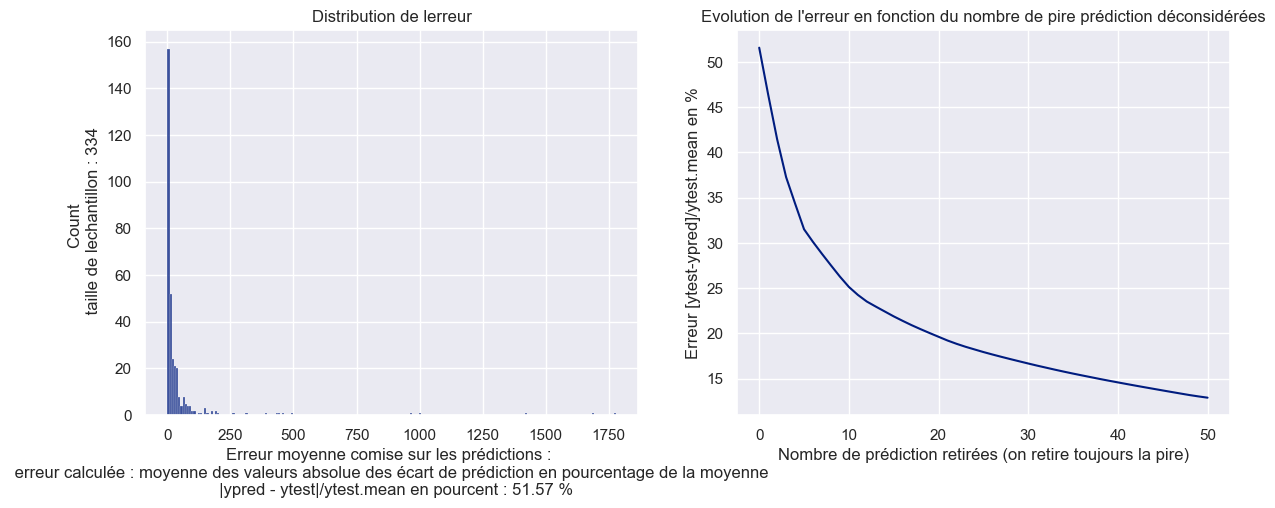

In [73]:
# test de la regression ridge à noyau. Premier True/false = passage au log, second = normalisation des données
test_lineaire_kernel(xtrain,ytrain,'rbf',True, True)

les meilleurs paramètres du modèle sont : {'alpha': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}


0
Mean_all_datas                 185.083448
Mean_test_sample               178.815841
Mean_predictions_of_sample       1.766357
Mae                            177.082616
Mse                         250896.861873
Mse_square_rooted              500.896059
R2_score                        -0.142603

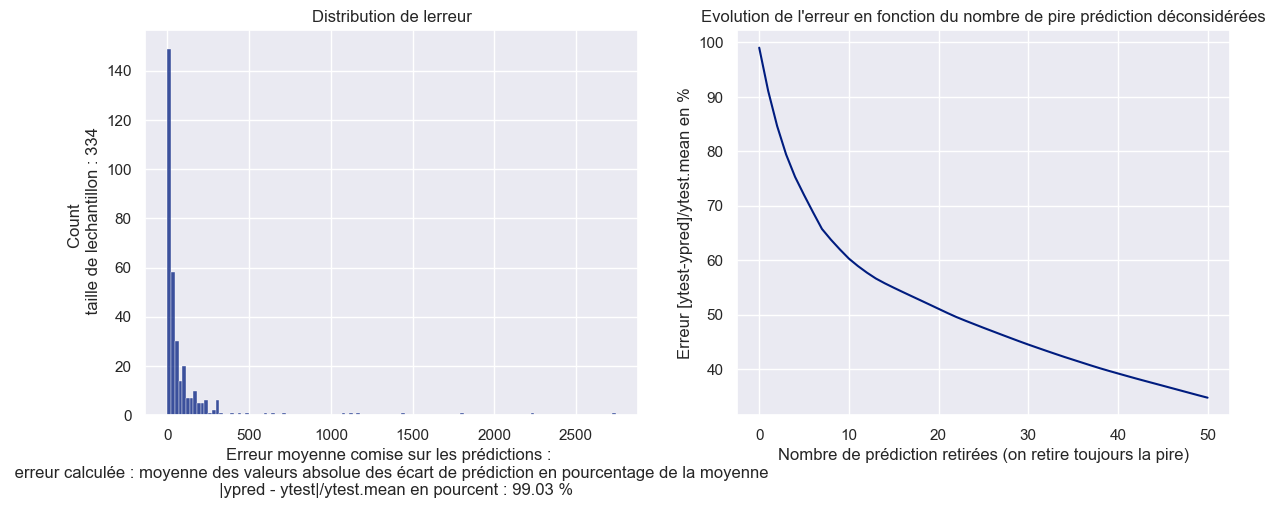

In [74]:
test_lineaire_kernel(xtrain,ytrain,'rbf',True, False)

les meilleurs paramètres du modèle sont : {'alpha': 1.6681005372000592, 'gamma': 0.1, 'kernel': 'rbf'}


0
Mean_all_datas                185.083448
Mean_test_sample              178.815841
Mean_predictions_of_sample    167.250614
Mae                           102.167830
Mse                         85649.481472
Mse_square_rooted             292.659327
R2_score                        0.609946

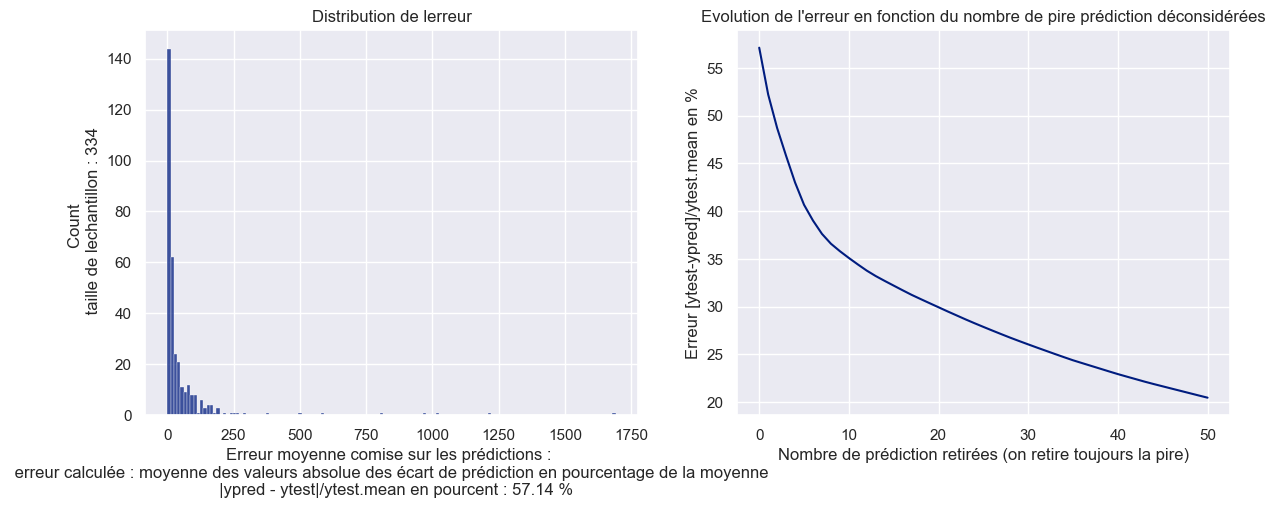

In [75]:
# test de la regression ridge à noyeau (gaussien), sans passage au log de la feature à prédire.
test_lineaire_kernel(xtrain,ytrain,'rbf',False, True)

les meilleurs paramètres du modèle sont : {'alpha': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}


0
Mean_all_datas                 185.083448
Mean_test_sample               178.815841
Mean_predictions_of_sample       4.762946
Mae                            175.235274
Mse                         249868.829882
Mse_square_rooted              499.868813
R2_score                        -0.137922

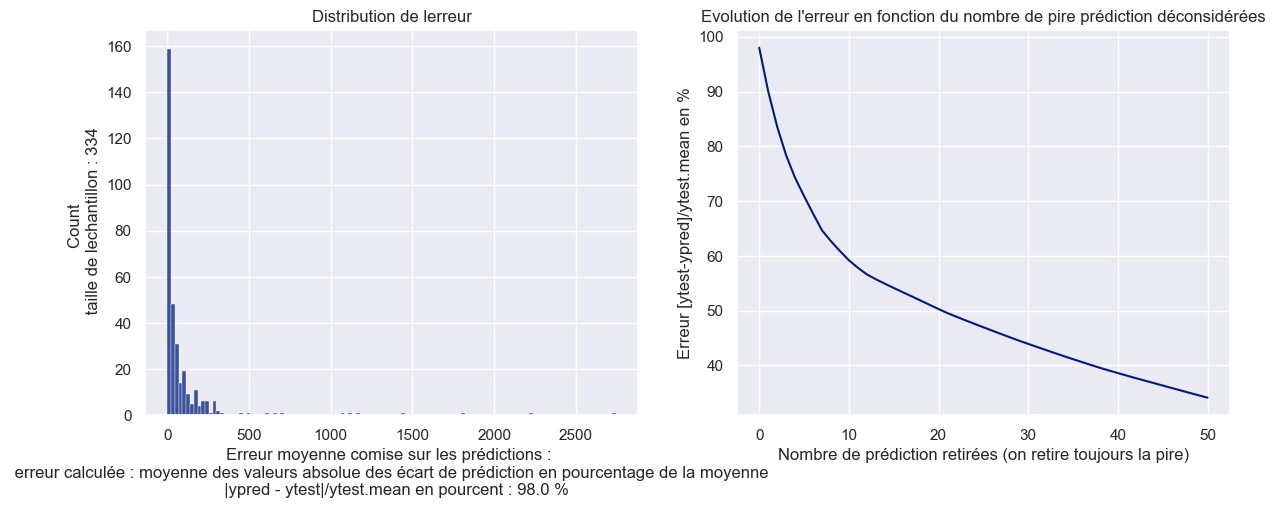

In [76]:
test_lineaire_kernel(xtrain,ytrain,'rbf',False, False)

les meilleurs paramètres du modèle sont : {'alpha': 4.6415888336127775, 'degree': 2, 'kernel': 'polynomial'}


0
Mean_all_datas              1.850834e+02
Mean_test_sample            1.788158e+02
Mean_predictions_of_sample  3.129476e+02
Mae                         2.723820e+02
Mse                         1.065527e+07
Mse_square_rooted           3.264241e+03
R2_score                   -4.752491e+01

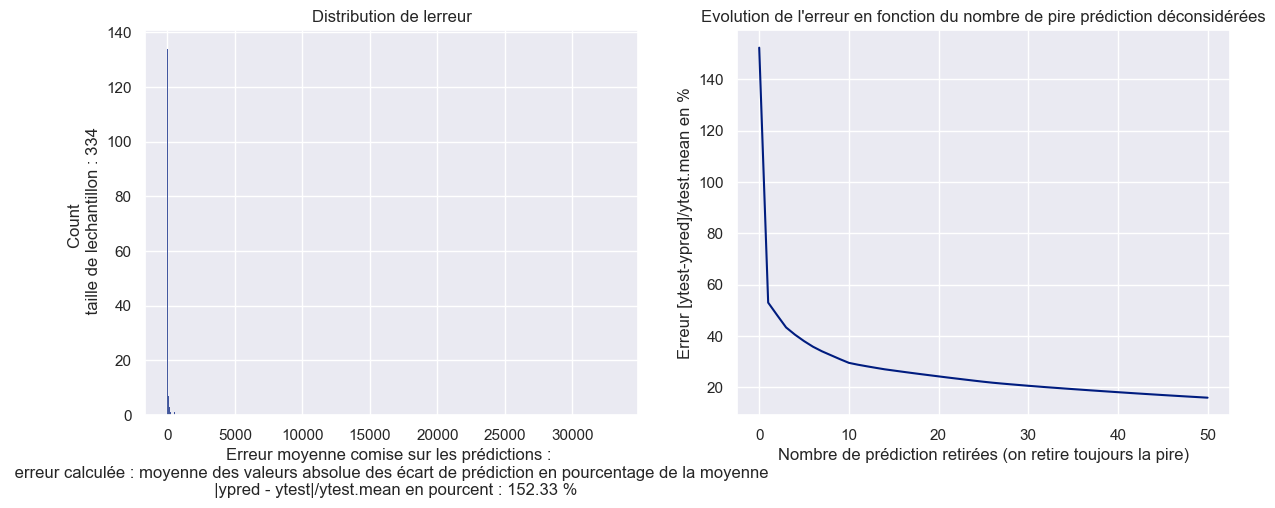

In [77]:
test_lineaire_kernel(xtrain,ytrain,'polynomial',True, True)

les meilleurs paramètres du modèle sont : {'alpha': 0.5994842503189409, 'degree': 2, 'kernel': 'polynomial'}


0
Mean_all_datas                 185.083448
Mean_test_sample               178.815841
Mean_predictions_of_sample     208.889291
Mae                            159.631200
Mse                         756286.434618
Mse_square_rooted              869.647305
R2_score                        -2.444186

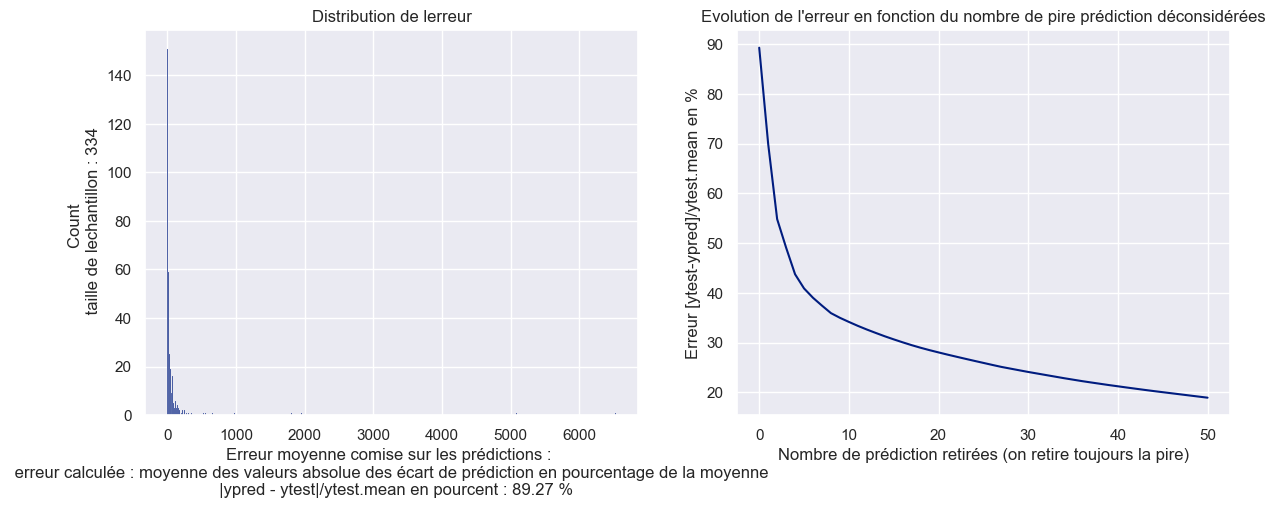

In [78]:
test_lineaire_kernel(xtrain,ytrain,'polynomial',True, False)

les meilleurs paramètres du modèle sont : {'alpha': 100.0, 'degree': 2, 'kernel': 'polynomial'}


0
Mean_all_datas                 185.083448
Mean_test_sample               178.815841
Mean_predictions_of_sample     185.237443
Mae                            145.224087
Mse                         151575.280135
Mse_square_rooted              389.326701
R2_score                         0.309715

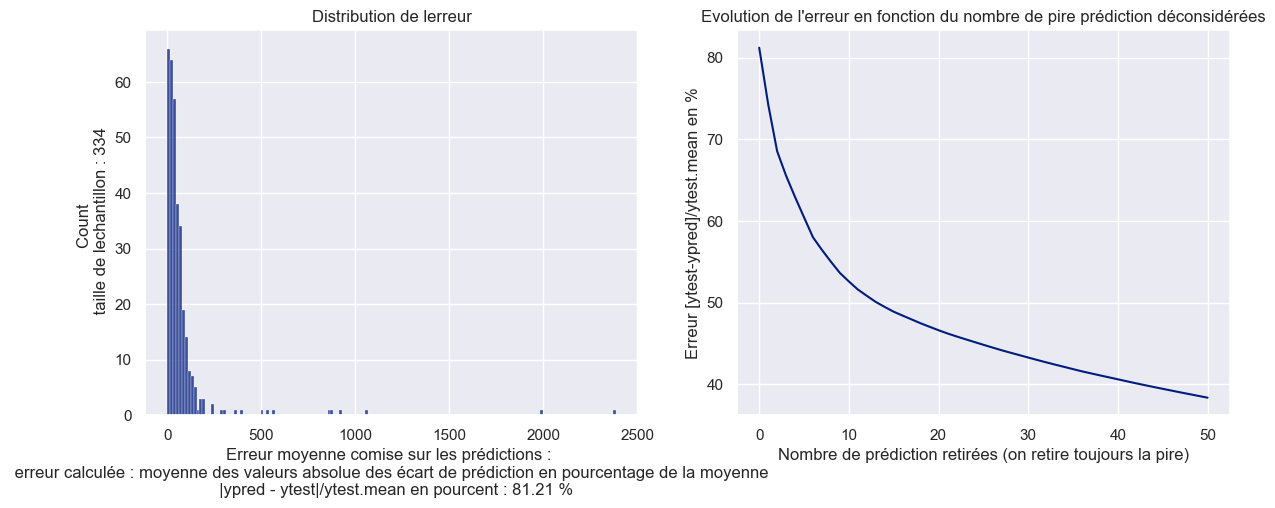

In [79]:
test_lineaire_kernel(xtrain,ytrain,'polynomial',False, True)

les meilleurs paramètres du modèle sont : {'alpha': 100.0, 'degree': 2, 'kernel': 'polynomial'}


0
Mean_all_datas                 185.083448
Mean_test_sample               178.815841
Mean_predictions_of_sample     205.909016
Mae                            143.805922
Mse                         188504.749173
Mse_square_rooted              434.171336
R2_score                         0.141535

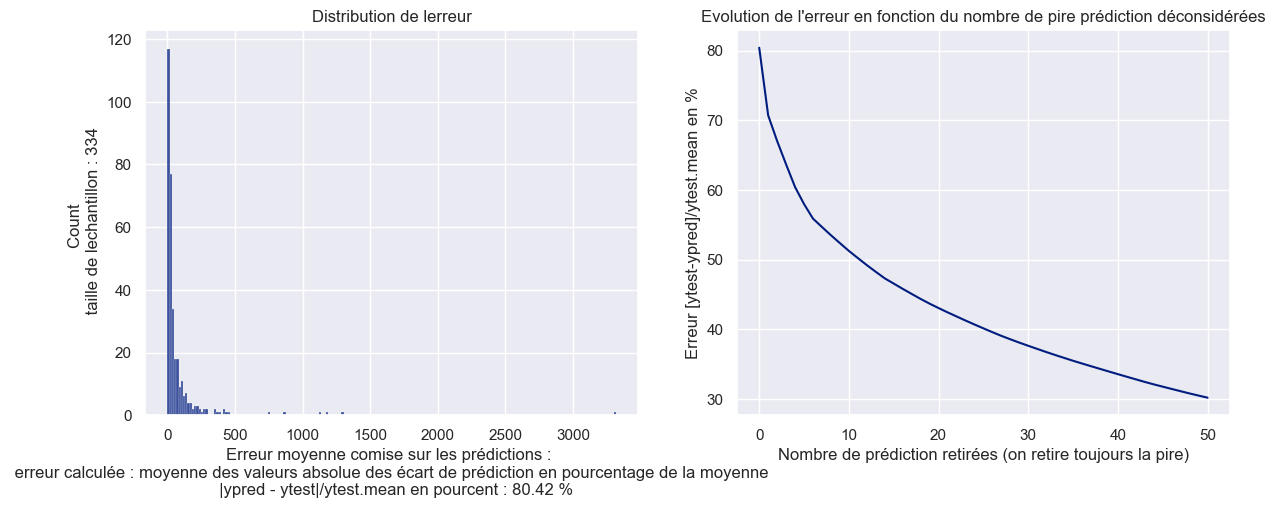

In [80]:
test_lineaire_kernel(xtrain,ytrain,'polynomial',False, False)

Epoch 1/150
67/67 [==============================] - 1s 1ms/step - loss: 17.2570 - accuracy: 0.0000e+00
Epoch 2/150
67/67 [==============================] - 0s 1ms/step - loss: 14.5814 - accuracy: 0.0000e+00
Epoch 3/150
67/67 [==============================] - 0s 1ms/step - loss: 9.1526 - accuracy: 0.0000e+00
Epoch 4/150
67/67 [==============================] - 0s 1ms/step - loss: 3.8752 - accuracy: 0.0000e+00
Epoch 5/150
67/67 [==============================] - 0s 1ms/step - loss: 2.4934 - accuracy: 0.0000e+00
Epoch 6/150
67/67 [==============================] - 0s 1ms/step - loss: 2.0574 - accuracy: 0.0000e+00
Epoch 7/150
67/67 [==============================] - 0s 1ms/step - loss: 1.8138 - accuracy: 0.0000e+00
Epoch 8/150
67/67 [==============================] - 0s 1ms/step - loss: 1.6496 - accuracy: 0.0000e+00
Epoch 9/150
67/67 [==============================] - 0s 1ms/step - loss: 1.5394 - accuracy: 0.0000e+00
Epoch 10/150
67/67 [==============================] - 0s 1ms/step - los

67/67 [==============================] - 0s 1ms/step - loss: 0.9642 - accuracy: 0.0000e+00
Epoch 80/150
67/67 [==============================] - 0s 1ms/step - loss: 0.9676 - accuracy: 0.0000e+00
Epoch 81/150
67/67 [==============================] - 0s 1ms/step - loss: 0.9603 - accuracy: 0.0000e+00
Epoch 82/150
67/67 [==============================] - 0s 1ms/step - loss: 0.9667 - accuracy: 0.0000e+00
Epoch 83/150
67/67 [==============================] - 0s 1ms/step - loss: 0.9596 - accuracy: 0.0000e+00
Epoch 84/150
67/67 [==============================] - 0s 1ms/step - loss: 0.9611 - accuracy: 0.0000e+00
Epoch 85/150
67/67 [==============================] - 0s 1ms/step - loss: 0.9637 - accuracy: 0.0000e+00
Epoch 86/150
67/67 [==============================] - 0s 1ms/step - loss: 0.9679 - accuracy: 0.0000e+00
Epoch 87/150
67/67 [==============================] - 0s 1ms/step - loss: 0.9605 - accuracy: 0.0000e+00
Epoch 88/150
67/67 [==============================] - 0s 1ms/step - loss: 0.9

0
Mean_all_datas                 185.083448
Mean_test_sample               178.815841
Mean_predictions_of_sample     173.139526
Mae                            156.565759
Mse                         492908.090101
Mse_square_rooted              702.074134
R2_score                        -1.244741

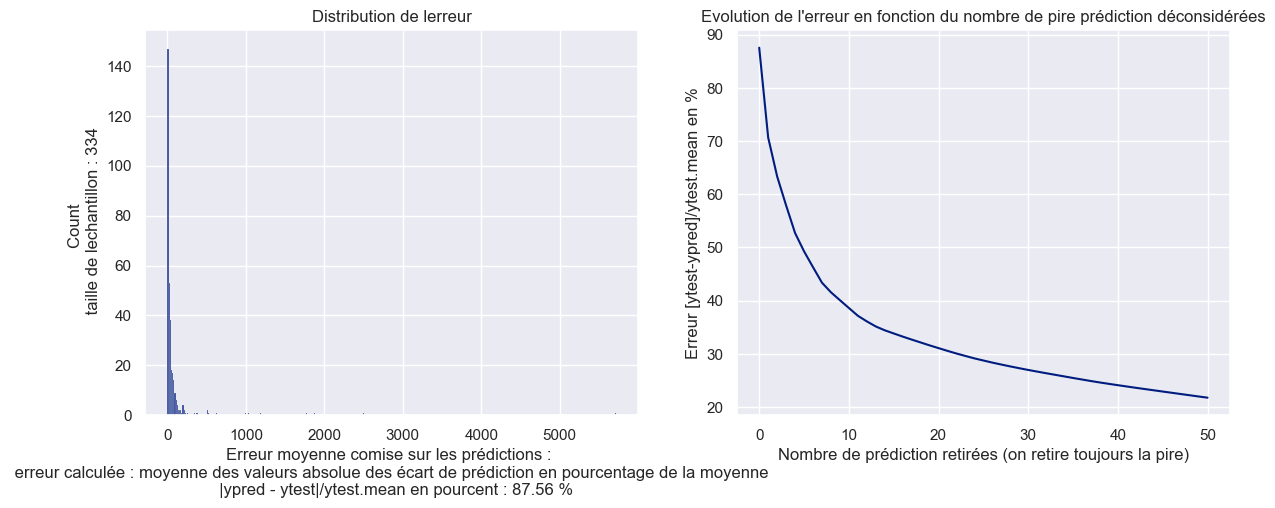

In [44]:
# Test du reseau de neurone avec et sans passage au log, avec 10 couches successives
test_neurone(xtrain,ytrain, 10, True, True)

Epoch 1/150
67/67 [==============================] - 1s 1ms/step - loss: 129435048.0000 - accuracy: 0.0000e+00
Epoch 2/150
67/67 [==============================] - 0s 1ms/step - loss: 79531216.0000 - accuracy: 0.0000e+00
Epoch 3/150
67/67 [==============================] - 0s 1ms/step - loss: 55834196.0000 - accuracy: 0.0000e+00
Epoch 4/150
67/67 [==============================] - 0s 1ms/step - loss: 41166300.0000 - accuracy: 0.0000e+00
Epoch 5/150
67/67 [==============================] - 0s 1ms/step - loss: 31584090.0000 - accuracy: 0.0000e+00
Epoch 6/150
67/67 [==============================] - 0s 1ms/step - loss: 24708080.0000 - accuracy: 0.0000e+00
Epoch 7/150
67/67 [==============================] - 0s 1ms/step - loss: 19783336.0000 - accuracy: 0.0000e+00
Epoch 8/150
67/67 [==============================] - 0s 1ms/step - loss: 16217524.0000 - accuracy: 0.0000e+00
Epoch 9/150
67/67 [==============================] - 0s 1ms/step - loss: 13287450.0000 - accuracy: 0.0000e+00
Epoch 10/

67/67 [==============================] - 0s 1ms/step - loss: 439.4972 - accuracy: 0.0000e+00
Epoch 77/150
67/67 [==============================] - 0s 1ms/step - loss: 322.2995 - accuracy: 0.0000e+00
Epoch 78/150
67/67 [==============================] - 0s 1ms/step - loss: 235.0853 - accuracy: 0.0000e+00
Epoch 79/150
67/67 [==============================] - 0s 1ms/step - loss: 169.6700 - accuracy: 0.0000e+00
Epoch 80/150
67/67 [==============================] - 0s 1ms/step - loss: 122.2380 - accuracy: 0.0000e+00
Epoch 81/150
67/67 [==============================] - 0s 1ms/step - loss: 87.1702 - accuracy: 0.0000e+00
Epoch 82/150
67/67 [==============================] - 0s 1ms/step - loss: 62.1521 - accuracy: 0.0000e+00
Epoch 83/150
67/67 [==============================] - 0s 1ms/step - loss: 44.6807 - accuracy: 0.0000e+00
Epoch 84/150
67/67 [==============================] - 0s 1ms/step - loss: 31.9942 - accuracy: 0.0000e+00
Epoch 85/150
67/67 [==============================] - 0s 1ms/st

0
Mean_all_datas                 185.083448
Mean_test_sample               178.815841
Mean_predictions_of_sample       6.984568
Mae                            172.398724
Mse                         242869.161440
Mse_square_rooted              492.817574
R2_score                        -0.106045

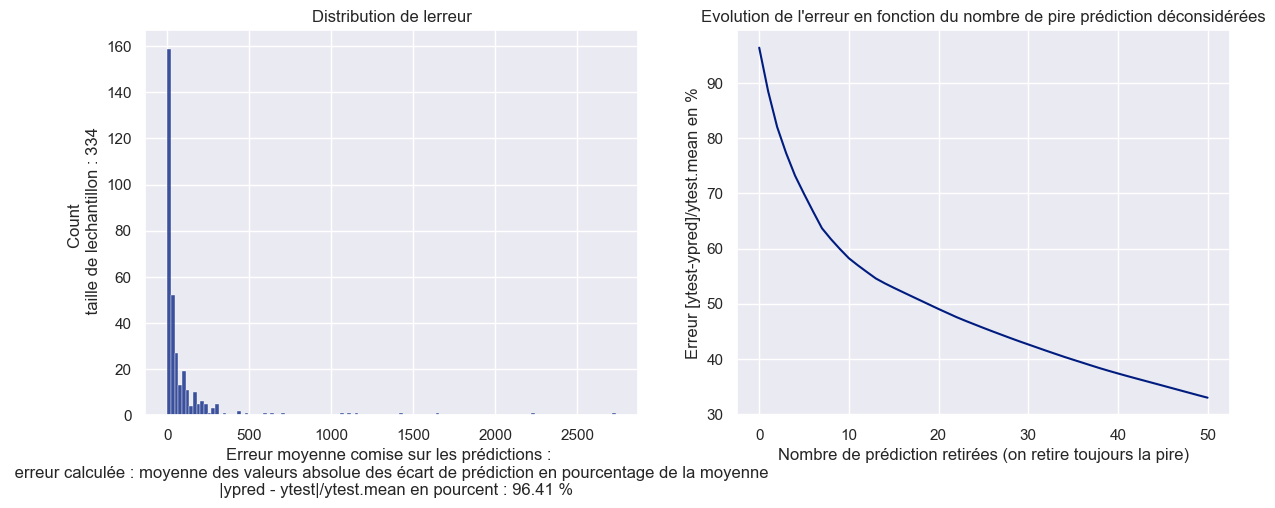

In [45]:
test_neurone(xtrain,ytrain, 10, True, False)

Epoch 1/150
67/67 [==============================] - 1s 1ms/step - loss: 685573.1875 - accuracy: 0.0000e+00
Epoch 2/150
67/67 [==============================] - 0s 1ms/step - loss: 685521.5625 - accuracy: 0.0000e+00
Epoch 3/150
67/67 [==============================] - 0s 1ms/step - loss: 685458.0000 - accuracy: 0.0000e+00
Epoch 4/150
67/67 [==============================] - 0s 1ms/step - loss: 685345.3125 - accuracy: 0.0000e+00
Epoch 5/150
67/67 [==============================] - 0s 1ms/step - loss: 685082.0000 - accuracy: 0.0000e+00
Epoch 6/150
67/67 [==============================] - 0s 1ms/step - loss: 684113.8125 - accuracy: 0.0000e+00
Epoch 7/150
67/67 [==============================] - 0s 1ms/step - loss: 680554.4375 - accuracy: 0.0000e+00
Epoch 8/150
67/67 [==============================] - 0s 1ms/step - loss: 670649.8750 - accuracy: 0.0000e+00
Epoch 9/150
67/67 [==============================] - 0s 1ms/step - loss: 652118.8125 - accuracy: 0.0000e+00
Epoch 10/150
67/67 [========

67/67 [==============================] - 0s 1ms/step - loss: 422144.2500 - accuracy: 0.0000e+00
Epoch 77/150
67/67 [==============================] - 0s 1ms/step - loss: 422537.6562 - accuracy: 0.0000e+00
Epoch 78/150
67/67 [==============================] - 0s 1ms/step - loss: 422076.7500 - accuracy: 0.0000e+00
Epoch 79/150
67/67 [==============================] - 0s 1ms/step - loss: 423470.8125 - accuracy: 0.0000e+00
Epoch 80/150
67/67 [==============================] - 0s 1ms/step - loss: 422753.5312 - accuracy: 0.0000e+00
Epoch 81/150
67/67 [==============================] - 0s 1ms/step - loss: 422606.1875 - accuracy: 0.0000e+00
Epoch 82/150
67/67 [==============================] - 0s 1ms/step - loss: 423882.0625 - accuracy: 0.0000e+00
Epoch 83/150
67/67 [==============================] - 0s 1ms/step - loss: 421560.5625 - accuracy: 0.0000e+00
Epoch 84/150
67/67 [==============================] - 0s 1ms/step - loss: 421272.5625 - accuracy: 0.0000e+00
Epoch 85/150
67/67 [============

11/11 [==============================] - 0s 1ms/step


0
Mean_all_datas                 185.083448
Mean_test_sample               178.815841
Mean_predictions_of_sample     206.752380
Mae                            191.072070
Mse                         146840.519318
Mse_square_rooted              383.197755
R2_score                         0.331277

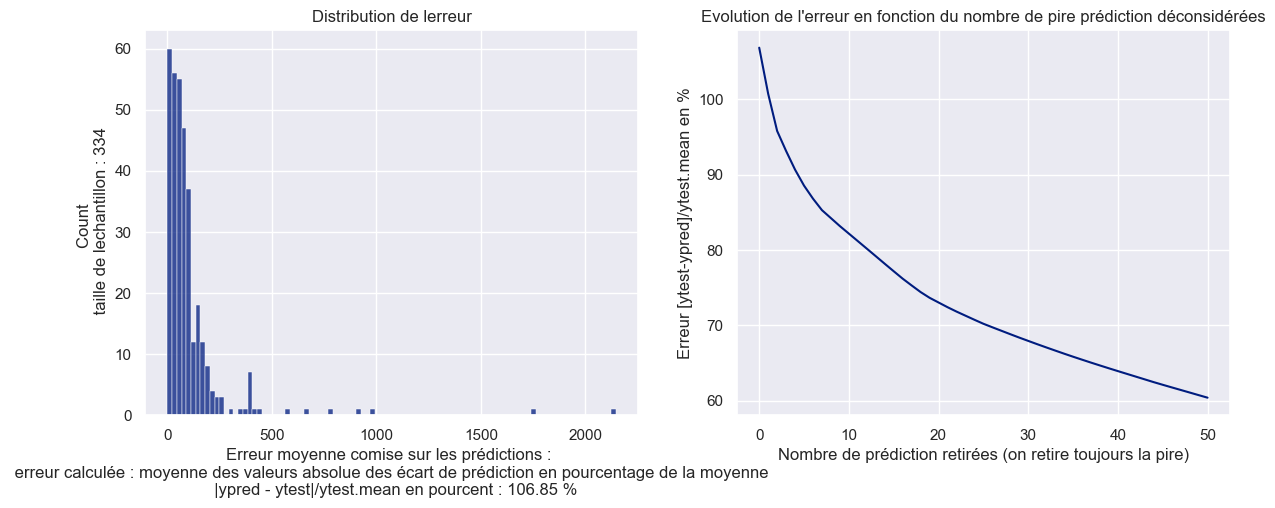

In [46]:
test_neurone(xtrain,ytrain, 10, False, True)

Epoch 1/150
67/67 [==============================] - 1s 1ms/step - loss: 10019438.0000 - accuracy: 0.0000e+00
Epoch 2/150
67/67 [==============================] - 0s 1ms/step - loss: 6295313.5000 - accuracy: 0.0000e+00
Epoch 3/150
67/67 [==============================] - 0s 1ms/step - loss: 3911061.0000 - accuracy: 0.0000e+00
Epoch 4/150
67/67 [==============================] - 0s 1ms/step - loss: 2628678.2500 - accuracy: 0.0000e+00
Epoch 5/150
67/67 [==============================] - 0s 1ms/step - loss: 2093245.2500 - accuracy: 0.0000e+00
Epoch 6/150
67/67 [==============================] - 0s 1ms/step - loss: 1462396.6250 - accuracy: 0.0000e+00
Epoch 7/150
67/67 [==============================] - 0s 1ms/step - loss: 1173566.5000 - accuracy: 0.0000e+00
Epoch 8/150
67/67 [==============================] - 0s 1ms/step - loss: 1014342.6250 - accuracy: 0.0000e+00
Epoch 9/150
67/67 [==============================] - 0s 1ms/step - loss: 837905.8750 - accuracy: 0.0000e+00
Epoch 10/150
67/67 

67/67 [==============================] - 0s 1ms/step - loss: 465066.5625 - accuracy: 0.0000e+00
Epoch 77/150
67/67 [==============================] - 0s 1ms/step - loss: 466000.5625 - accuracy: 0.0000e+00
Epoch 78/150
67/67 [==============================] - 0s 1ms/step - loss: 468723.2812 - accuracy: 0.0000e+00
Epoch 79/150
67/67 [==============================] - 0s 1ms/step - loss: 467413.7188 - accuracy: 0.0000e+00
Epoch 80/150
67/67 [==============================] - 0s 1ms/step - loss: 466385.1250 - accuracy: 0.0000e+00
Epoch 81/150
67/67 [==============================] - 0s 1ms/step - loss: 464712.2188 - accuracy: 0.0000e+00
Epoch 82/150
67/67 [==============================] - 0s 1ms/step - loss: 469201.4688 - accuracy: 0.0000e+00
Epoch 83/150
67/67 [==============================] - 0s 1ms/step - loss: 467487.0000 - accuracy: 0.0000e+00
Epoch 84/150
67/67 [==============================] - 0s 1ms/step - loss: 464258.6875 - accuracy: 0.0000e+00
Epoch 85/150
67/67 [============

11/11 [==============================] - 0s 1000us/step


0
Mean_all_datas                 185.083448
Mean_test_sample               178.815841
Mean_predictions_of_sample     155.540497
Mae                            138.174987
Mse                         152421.831687
Mse_square_rooted              390.412387
R2_score                         0.305859

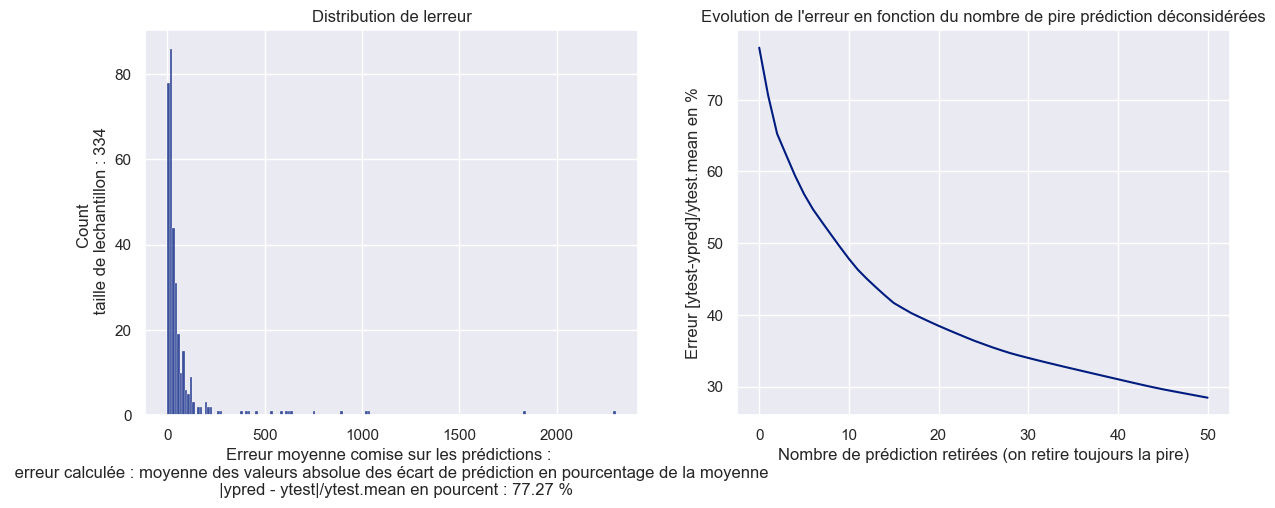

In [47]:
test_neurone(xtrain,ytrain, 10, False, False)

0
Mean_all_datas                185.083448
Mean_test_sample              178.815841
Mean_predictions_of_sample    141.223186
Mae                            69.563433
Mse                         45669.504414
Mse_square_rooted             213.704245
R2_score                        0.792018

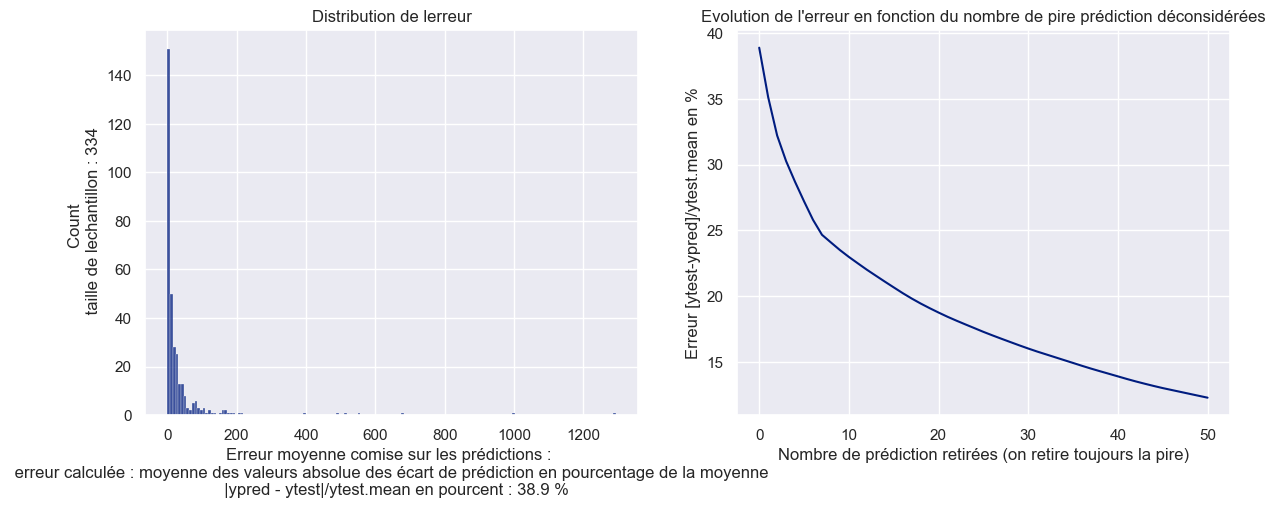

In [48]:
# Nous étudions maintenant un candidat sérieux : la random forest. Faisons un premier test avec des valeurs de paramètres
# arbitraires, puis faisons par la suite une validation croisée. testons aussi la différence quand on procède à
# un passage au log, ou pas.

# Num 1 : passage au log et normalisation

model = RandomForestRegressor(n_estimators=5000, criterion = 'squared_error', bootstrap = True, oob_score=True)
model.fit(centre_et_norme(xtrain),passagelog(ytrain,True))
y_pred = model.predict(centre_et_norme(xtest))
fig, ax = plt.subplots(ncols=2,figsize=(14, 5))
plt.sca(ax[0])
erreur_regression(ytest,y_pred,True)
plt.sca(ax[1])
evolution_erreur(ytest,y_pred,True)
ensembles_indicateur_qualite_prediction(ytest,y_pred, True)

0
Mean_all_datas                185.083448
Mean_test_sample              178.815841
Mean_predictions_of_sample    141.056848
Mae                            69.589283
Mse                         45760.712448
Mse_square_rooted             213.917537
R2_score                        0.791602

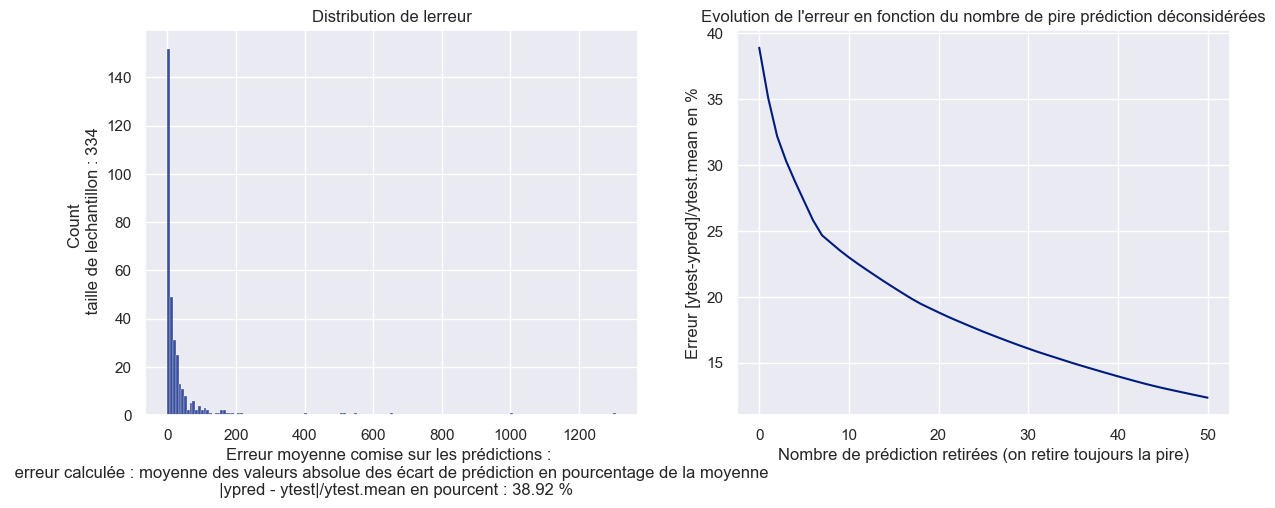

In [49]:
# Num 2 : passage au log sans normalisation

model = RandomForestRegressor(n_estimators=5000, criterion = 'squared_error', bootstrap = True, oob_score=True)
model.fit(xtrain,passagelog(ytrain,True))
y_pred = model.predict(xtest)
fig, ax = plt.subplots(ncols=2,figsize=(14, 5))
plt.sca(ax[0])
erreur_regression(ytest,y_pred,True)
plt.sca(ax[1])
evolution_erreur(ytest,y_pred,True)
ensembles_indicateur_qualite_prediction(ytest,y_pred, True)

0
Mean_all_datas                185.083448
Mean_test_sample              178.815841
Mean_predictions_of_sample    193.378329
Mae                            84.589999
Mse                         82014.245291
Mse_square_rooted             286.381294
R2_score                        0.626501

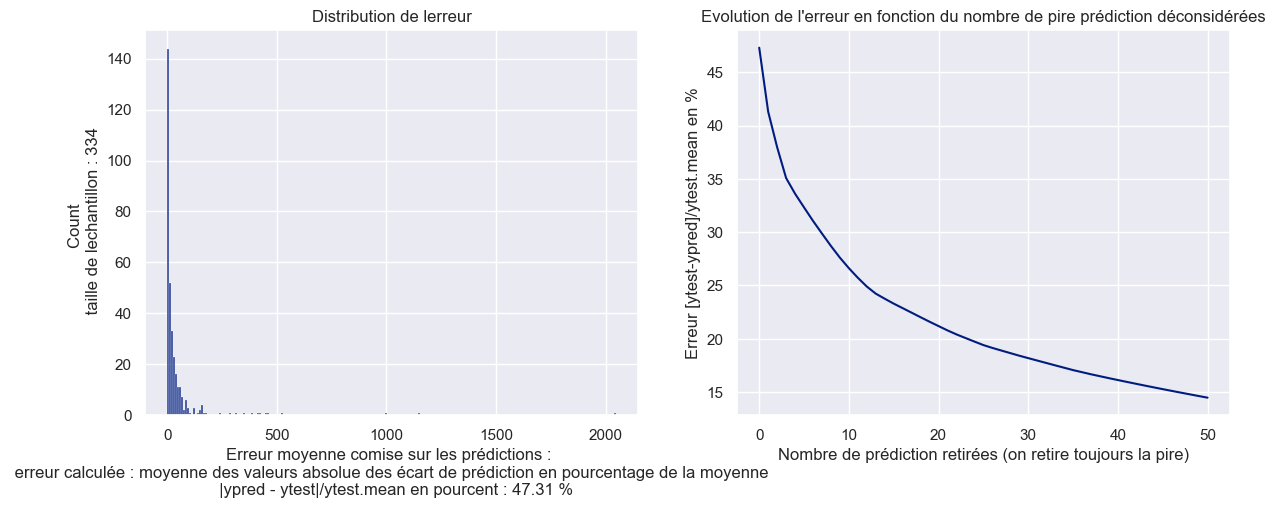

In [50]:
# Num 3 : pas de passage au log avec normalisation

model = RandomForestRegressor(n_estimators=5000, criterion = 'squared_error', bootstrap = True, oob_score=True)
model.fit(centre_et_norme(xtrain),ytrain)
y_pred = model.predict(centre_et_norme(xtest))
fig, ax = plt.subplots(ncols=2,figsize=(14, 5))
plt.sca(ax[0])
erreur_regression(ytest,y_pred,False)
plt.sca(ax[1])
evolution_erreur(ytest,y_pred,False)
ensembles_indicateur_qualite_prediction(ytest,y_pred, False)

0
Mean_all_datas                185.083448
Mean_test_sample              178.815841
Mean_predictions_of_sample    193.654756
Mae                            84.095117
Mse                         80084.025378
Mse_square_rooted             282.991211
R2_score                        0.635291

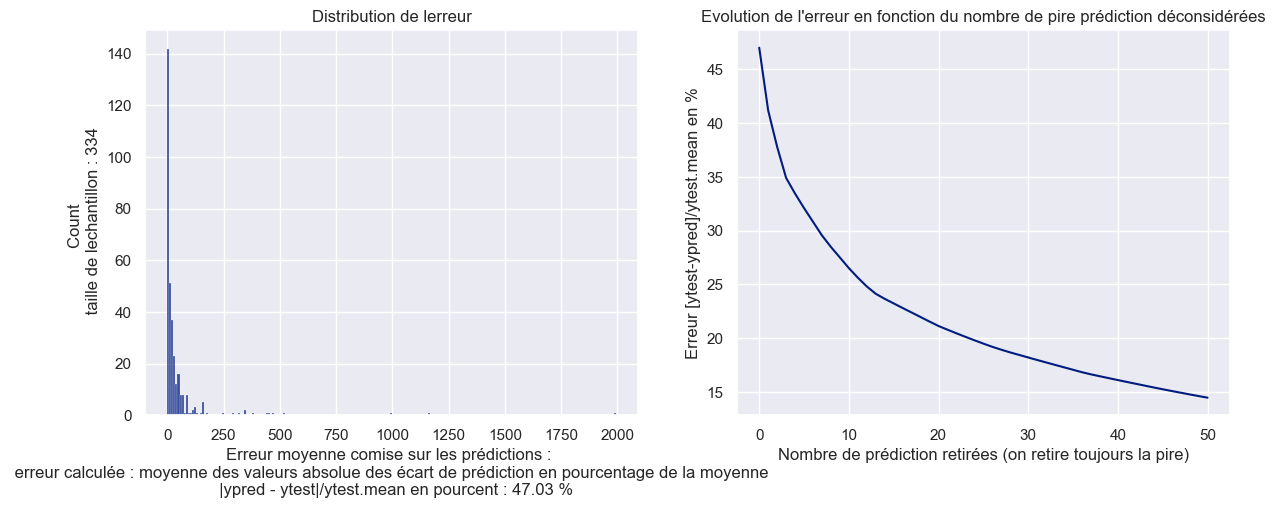

In [51]:
# Num 4 : pas de passage au log sans normalisation

model = RandomForestRegressor(n_estimators=5000, criterion = 'squared_error', bootstrap = True, oob_score=True)
model.fit(xtrain,ytrain,)
y_pred = model.predict(xtest)
fig, ax = plt.subplots(ncols=2,figsize=(14, 5))
plt.sca(ax[0])
erreur_regression(ytest,y_pred,False)
plt.sca(ax[1])
evolution_erreur(ytest,y_pred,False)
ensembles_indicateur_qualite_prediction(ytest,y_pred, False)

les meilleurs paramètres du modèle sont : {'bootstrap': True, 'criterion': 'squared_error', 'max_features': 13, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 5000, 'oob_score': True}


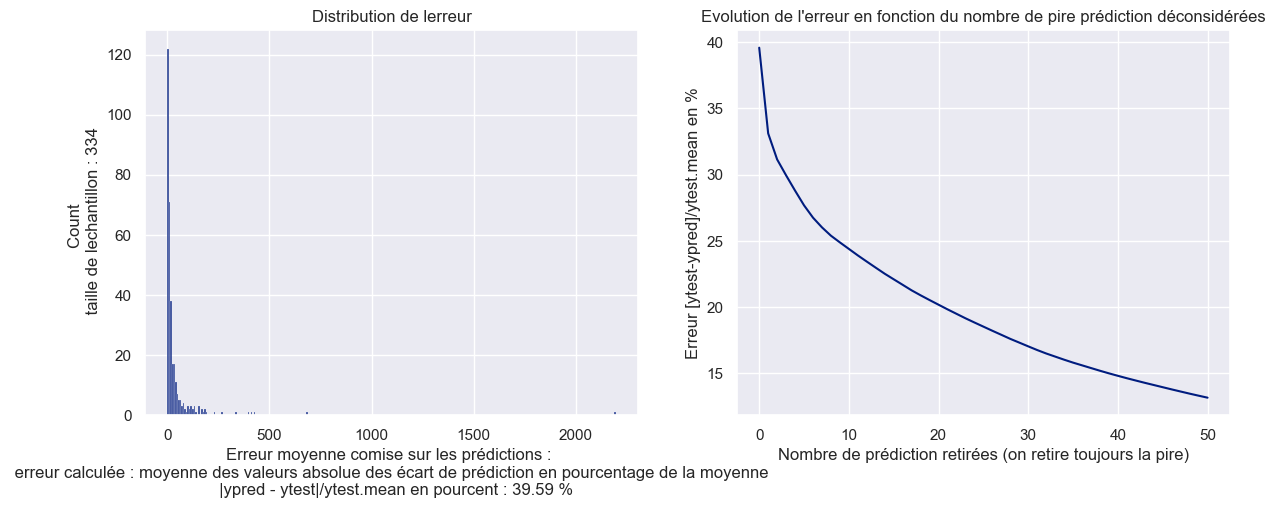

In [31]:
# testons par validation croisée l'ensemble des paramètres suivant :

param = {'n_estimators' : [1000, 5000],
         'criterion' : ['squared_error', 'absolute_error'], 
         'bootstrap' : [True],
         'oob_score' : [True],
         'min_samples_leaf' : [1,2,5],
         'min_samples_split' : [1,2,5],
         'max_features' : [1, int(xtrain.shape[1]*0.5), xtrain.shape[1]],
        }


clf = model_selection.GridSearchCV(
    RandomForestRegressor(), 
    param,    
    cv=5,
    scoring = 'neg_mean_absolute_error')
clf.fit(centre_et_norme(xtrain), passagelog(ytrain,True))
y_pred = clf.predict(centre_et_norme(xtest))
fig, ax = plt.subplots(ncols=2,figsize=(14, 5))
plt.sca(ax[0])
erreur_regression(ytest,y_pred,True)
plt.sca(ax[1])
evolution_erreur(ytest,y_pred,True)
print(f'les meilleurs paramètres du modèle sont : {clf.best_params_}')

0
Mean_all_datas                 185.083448
Mean_test_sample               178.815841
Mean_predictions_of_sample     116.755965
Mae                             87.301148
Mse                         107720.653132
Mse_square_rooted              328.208247
R2_score                         0.509432

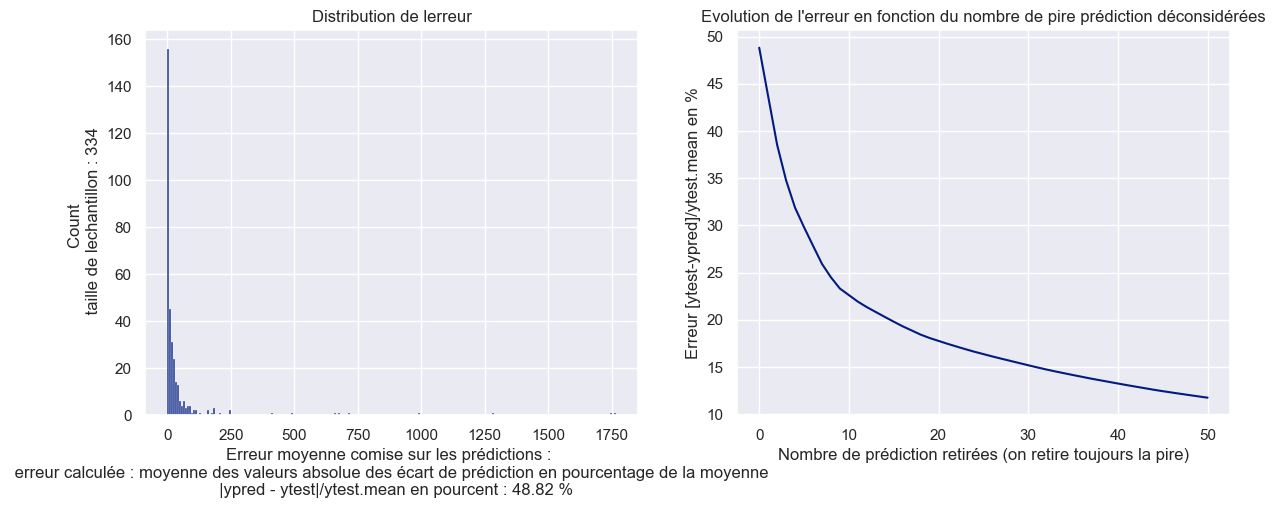

In [52]:
# Testons maintenant deux méthodes ensembliste : le bagging (parallèle) et le gradient booster (en série), toujours en 
# comparant les passage au log ou pas. (Bon, on a bien vu que c'était meilleur de le faire)

# Num1 : avec log et scaler :

bagging = BaggingRegressor(RandomForestRegressor(n_estimators=5000, criterion = 'absolute_error',
                                                 bootstrap = True, oob_score=True, max_features = 16,
                                                 min_samples_leaf = 2, min_samples_split = 5), 
                            n_estimators = 10, 
                            oob_score = True)
bagging.fit(centre_et_norme(xtrain),passagelog(ytrain,True))
y_pred = bagging.predict(centre_et_norme(xtest))

fig, ax = plt.subplots(ncols=2,figsize=(14, 5))
plt.sca(ax[0])
erreur_regression(ytest,y_pred,True)
plt.sca(ax[1])
evolution_erreur(ytest,y_pred,True)
ensembles_indicateur_qualite_prediction(ytest,y_pred, True)

0
Mean_all_datas                 185.083448
Mean_test_sample               178.815841
Mean_predictions_of_sample     114.982999
Mae                             87.705178
Mse                         105414.112969
Mse_square_rooted              324.675396
R2_score                         0.519936

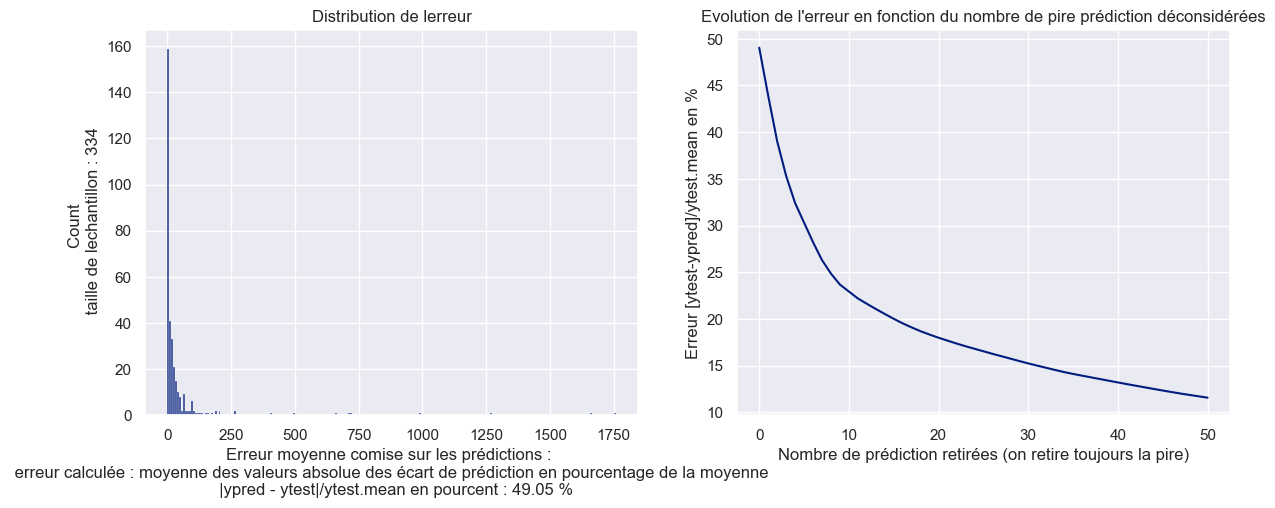

In [53]:
# Num2 : avec log sans scaler :

bagging = BaggingRegressor(RandomForestRegressor(n_estimators=5000, criterion = 'absolute_error',
                                                 bootstrap = True, oob_score=True, max_features = 16,
                                                 min_samples_leaf = 2, min_samples_split = 5), 
                                                 n_estimators = 10, 
                                                 oob_score = True)
bagging.fit(xtrain,passagelog(ytrain,True))
y_pred = bagging.predict(xtest)

fig, ax = plt.subplots(ncols=2,figsize=(14, 5))
plt.sca(ax[0])
erreur_regression(ytest,y_pred,True)
plt.sca(ax[1])
evolution_erreur(ytest,y_pred,True)
ensembles_indicateur_qualite_prediction(ytest,y_pred, True)

0
Mean_all_datas                185.083448
Mean_test_sample              178.815841
Mean_predictions_of_sample    188.428406
Mae                            83.051397
Mse                         47714.306014
Mse_square_rooted             218.436046
R2_score                        0.782705

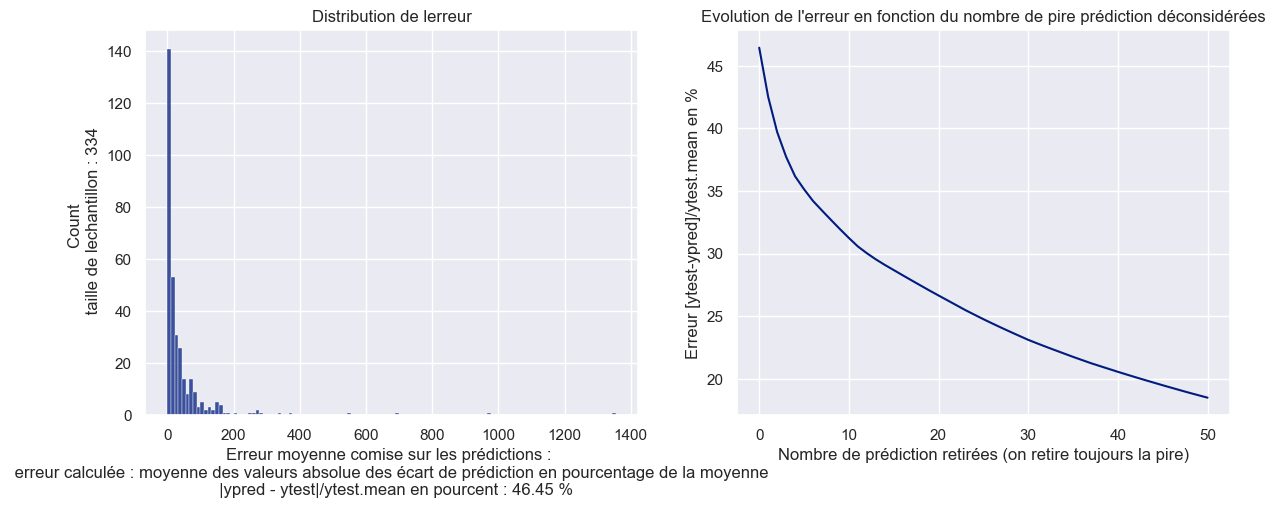

In [54]:
# Num3 : sans log avec scaler :

bagging = BaggingRegressor(RandomForestRegressor(n_estimators=5000, criterion = 'absolute_error',
                                                 bootstrap = True, oob_score=True, max_features = 16,
                                                 min_samples_leaf = 2, min_samples_split = 5), 
                            n_estimators = 10, 
                            oob_score = True)
bagging.fit(centre_et_norme(xtrain),ytrain)
y_pred = bagging.predict(centre_et_norme(xtest))

fig, ax = plt.subplots(ncols=2,figsize=(14, 5))
plt.sca(ax[0])
erreur_regression(ytest,y_pred,False)
plt.sca(ax[1])
evolution_erreur(ytest,y_pred,False)
ensembles_indicateur_qualite_prediction(ytest,y_pred, False)

0
Mean_all_datas                185.083448
Mean_test_sample              178.815841
Mean_predictions_of_sample    180.906028
Mae                            88.414754
Mse                         67403.729682
Mse_square_rooted             259.622283
R2_score                        0.693038

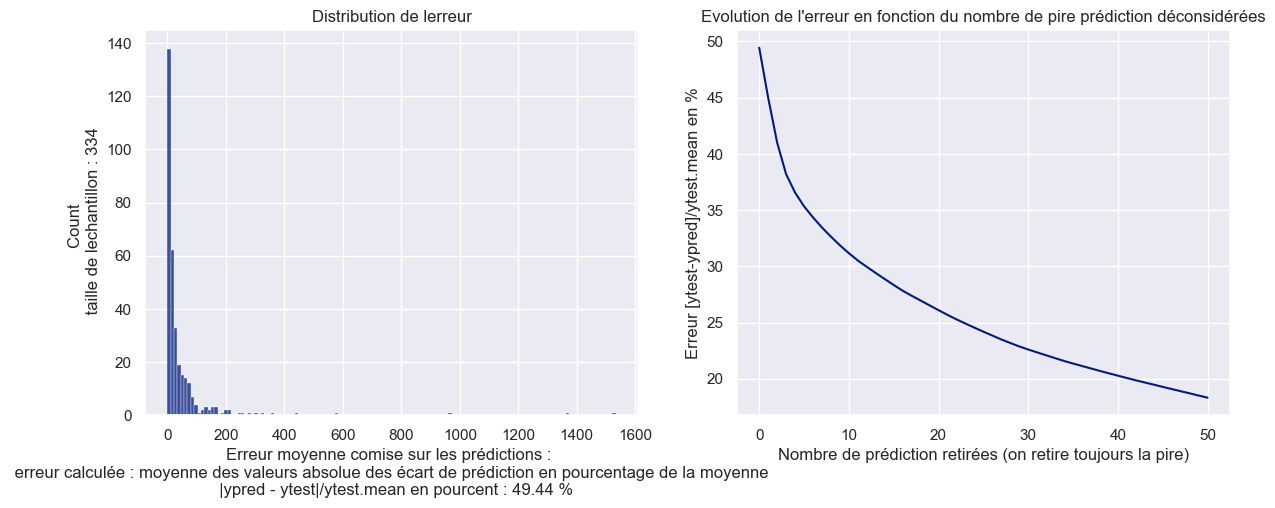

In [55]:
# Num4 : sans log et sans scaler :

bagging = BaggingRegressor(RandomForestRegressor(n_estimators=5000, criterion = 'absolute_error',
                                                 bootstrap = True, oob_score=True, max_features = 16,
                                                 min_samples_leaf = 2, min_samples_split = 5), 
                            n_estimators = 10, 
                            oob_score = True)
bagging.fit(xtrain,ytrain)
y_pred = bagging.predict(xtest)

fig, ax = plt.subplots(ncols=2,figsize=(14, 5))
plt.sca(ax[0])
erreur_regression(ytest,y_pred,False)
plt.sca(ax[1])
evolution_erreur(ytest,y_pred,False)
ensembles_indicateur_qualite_prediction(ytest,y_pred, False)

les meilleurs paramètres du modèle sont : {'base_estimator': RandomForestRegressor(criterion='absolute_error', max_features=16,
                      min_samples_leaf=2, min_samples_split=5,
                      n_estimators=5000, oob_score=True), 'max_features': 27, 'n_estimators': 100, 'oob_score': True}


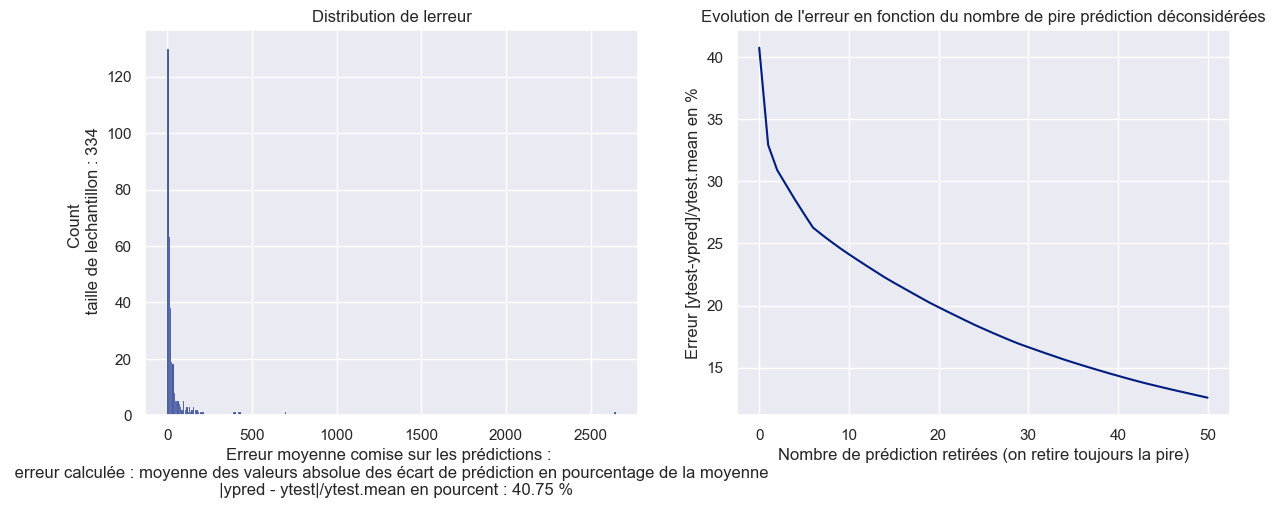

In [40]:
# Nous avons deux candidat sérieux pour les méthodes ensembliste, et sans surprise, le bagging, et le gradient booster.
# Etudions sur les deux la validation croisée pour les départager :

param = {'base_estimator' : [RandomForestRegressor(n_estimators=5000, criterion = 'absolute_error',
                                                 bootstrap = True, oob_score=True, max_features = 16,
                                                 min_samples_leaf = 2, min_samples_split = 5)], 
         'n_estimators' : [10, 50, 100],
         'oob_score' : [True],
         'max_features' : [int(xtrain.shape[1]*0.5), xtrain.shape[1]]
        }


clf0 = model_selection.GridSearchCV(
    BaggingRegressor(), 
    param,    
    cv=5,
    scoring = 'neg_mean_absolute_error')
clf0.fit(centre_et_norme(xtrain), passagelog(ytrain,True))
y_pred = clf0.predict(centre_et_norme(xtest))
fig, ax = plt.subplots(ncols=2,figsize=(14, 5))
plt.sca(ax[0])
erreur_regression(ytest,y_pred,True)
plt.sca(ax[1])
evolution_erreur(ytest,y_pred,True)
print(f'les meilleurs paramètres du modèle sont : {clf0.best_params_}')

0
Mean_all_datas                185.083448
Mean_test_sample              178.815841
Mean_predictions_of_sample    131.596870
Mae                            75.507397
Mse                         64451.866793
Mse_square_rooted             253.873722
R2_score                        0.706481

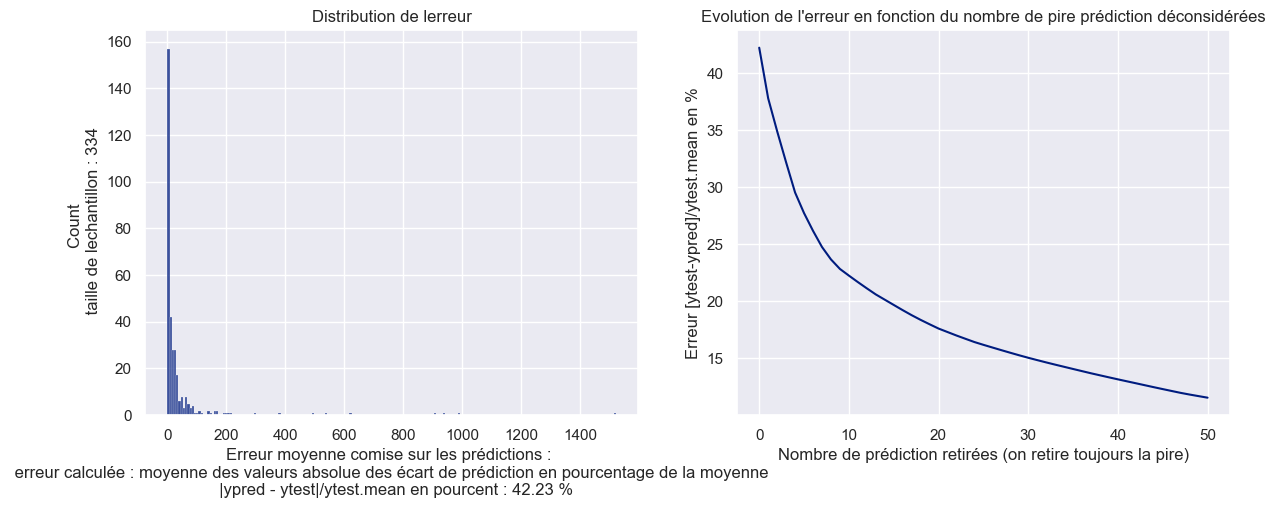

In [56]:
# on est reparti pour le gradient booster :

# num 1 : avec log et normalisation

model = GradientBoostingRegressor(init = RandomForestRegressor(n_estimators=5000, criterion = 'absolute_error',
                                                 bootstrap = True, oob_score=True, max_features = 16,
                                                 min_samples_leaf = 2, min_samples_split = 5), 
                                                 n_estimators = 10,
                                                 loss='squared_error',
                                                 learning_rate=0.1, 
                                                 criterion = 'squared_error')
model.fit(centre_et_norme(xtrain),passagelog(ytrain,True))
y_pred = model.predict(centre_et_norme(xtest))

fig, ax = plt.subplots(ncols=2,figsize=(14, 5))
plt.sca(ax[0])
erreur_regression(ytest,y_pred,True)
plt.sca(ax[1])
evolution_erreur(ytest,y_pred,True)
ensembles_indicateur_qualite_prediction(ytest,y_pred, True)

0
Mean_all_datas                185.083448
Mean_test_sample              178.815841
Mean_predictions_of_sample    132.524104
Mae                            74.327181
Mse                         60702.335136
Mse_square_rooted             246.378439
R2_score                        0.723557

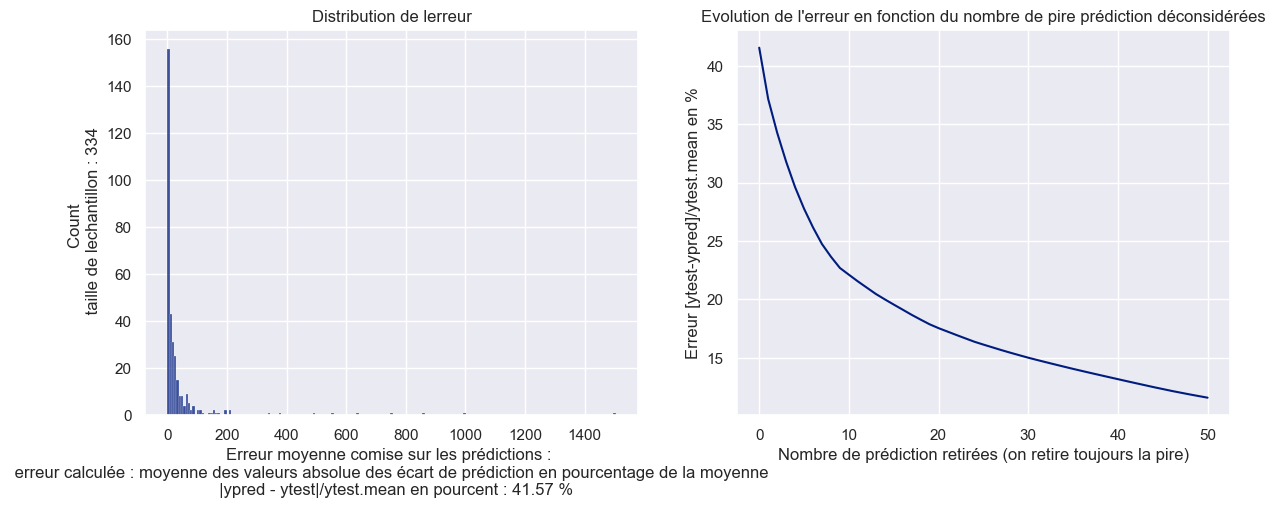

In [57]:
# num 2 : avec log sans normalisation

model = GradientBoostingRegressor(init = RandomForestRegressor(n_estimators=5000, criterion = 'absolute_error',
                                                 bootstrap = True, oob_score=True, max_features = 16,
                                                 min_samples_leaf = 2, min_samples_split = 5), 
                                  n_estimators = 10,
                                  loss='squared_error',
                                  learning_rate=0.1, 
                                  criterion = 'squared_error')
model.fit(xtrain,passagelog(ytrain,True))
y_pred = model.predict(xtest)

fig, ax = plt.subplots(ncols=2,figsize=(14, 5))
plt.sca(ax[0])
erreur_regression(ytest,y_pred,True)
plt.sca(ax[1])
evolution_erreur(ytest,y_pred,True)
ensembles_indicateur_qualite_prediction(ytest,y_pred, True)

0
Mean_all_datas                185.083448
Mean_test_sample              178.815841
Mean_predictions_of_sample    194.917682
Mae                            88.410221
Mse                         92387.065003
Mse_square_rooted             303.952406
R2_score                        0.579262

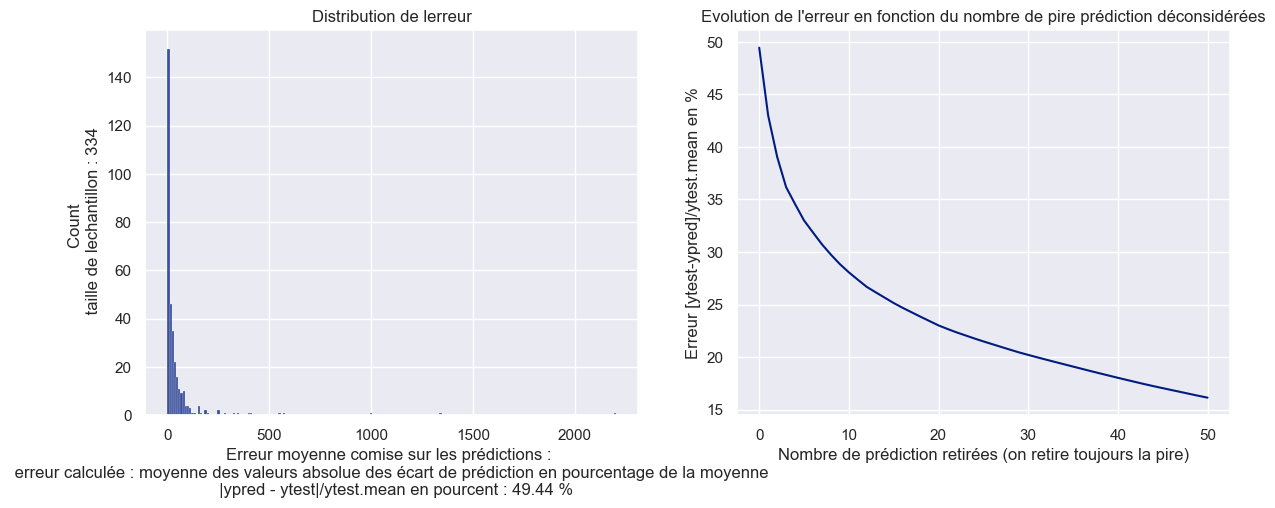

In [58]:
# num 3 : sans log avec normalisation

model = GradientBoostingRegressor(init = RandomForestRegressor(n_estimators=5000, criterion = 'absolute_error',
                                                 bootstrap = True, oob_score=True, max_features = 16,
                                                 min_samples_leaf = 2, min_samples_split = 5), 
                                  n_estimators = 10,
                                  loss='squared_error',
                                  learning_rate=0.1, 
                                  criterion = 'squared_error')
model.fit(centre_et_norme(xtrain),ytrain)
y_pred = model.predict(centre_et_norme(xtest))

fig, ax = plt.subplots(ncols=2,figsize=(14, 5))
plt.sca(ax[0])
erreur_regression(ytest,y_pred,False)
plt.sca(ax[1])
evolution_erreur(ytest,y_pred,False)
ensembles_indicateur_qualite_prediction(ytest,y_pred, False)

0
Mean_all_datas                185.083448
Mean_test_sample              178.815841
Mean_predictions_of_sample    194.906893
Mae                            87.735496
Mse                         92038.797932
Mse_square_rooted             303.378968
R2_score                        0.580848

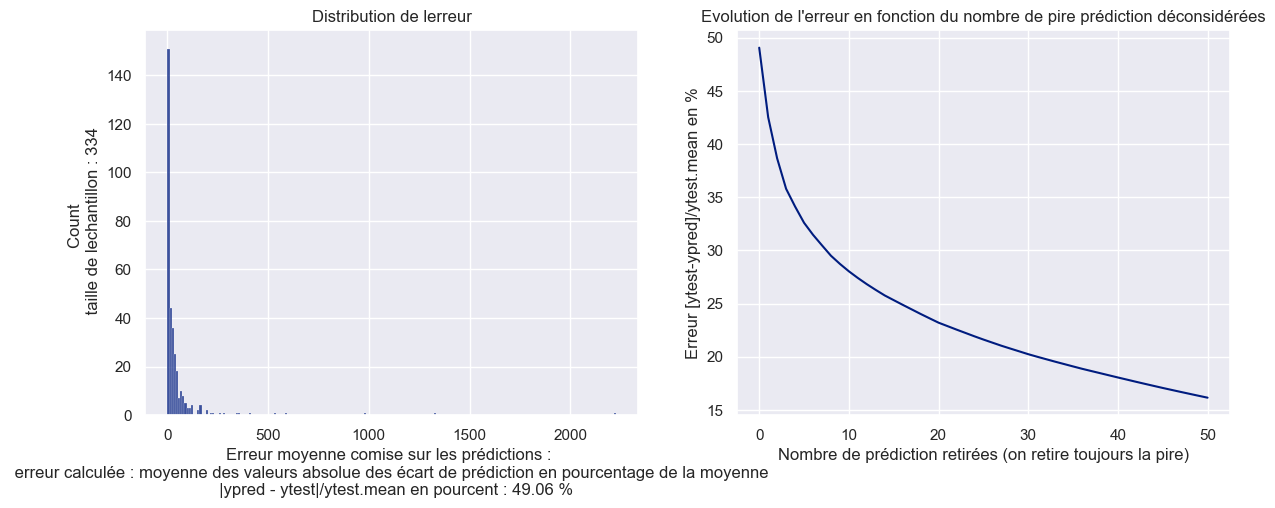

In [59]:
# num 4 : sans log et sans normalisation

model = GradientBoostingRegressor(init = RandomForestRegressor(n_estimators=5000, criterion = 'absolute_error',
                                                 bootstrap = True, oob_score=True, max_features = 16,
                                                 min_samples_leaf = 2, min_samples_split = 5), 
                                  n_estimators = 10,
                                  loss='squared_error',
                                  learning_rate=0.1, 
                                  criterion = 'squared_error')
model.fit(xtrain,ytrain)
y_pred = model.predict(xtest)

fig, ax = plt.subplots(ncols=2,figsize=(14, 5))
plt.sca(ax[0])
erreur_regression(ytest,y_pred,False)
plt.sca(ax[1])
evolution_erreur(ytest,y_pred,False)
ensembles_indicateur_qualite_prediction(ytest,y_pred, False)

In [ ]:
# Une dernière validation croisée sur nos deux méthodes ensembliste pour les départager avant de choisir notre modèle final :

param = {'init' : [RandomForestRegressor(n_estimators=1000, criterion = 'squared_error',
                                                 bootstrap = True, oob_score=True, max_features = 14,
                                                 min_samples_leaf = 2, min_samples_split = 5)], 
         'n_estimators' : [100, 200],
         'loss' : ['absolute_error'], 
         'learning_rate' : [0.2 , 0.1], 
         'criterion' : ['absolute_error']}


clf = model_selection.GridSearchCV(
    GradientBoostingRegressor(), 
    param,    
    cv=5,
    scoring = 'neg_mean_absolute_error')
clf.fit(centre_et_norme(xtrain), passagelog(ytrain,True))
y_pred = clf.predict(centre_et_norme(xtest))
fig, ax = plt.subplots(ncols=2,figsize=(14, 5))
plt.sca(ax[0])
erreur_regression(ytest,y_pred,True)
plt.sca(ax[1])
evolution_erreur(ytest,y_pred,True)
print(f'les meilleurs paramètres du modèle sont : {clf.best_params_}')
ensembles_indicateur_qualite_prediction(ytest,y_pred, True)


In [ ]:
valid_croisee = pd.DataFrame(clf.cv_results_)
valid_croisee.sort_values(by = 'rank_test_score').drop(columns = ['mean_fit_time','std_fit_time',
                                                                  'mean_score_time','std_score_time',
                                                                  'param_init', 'params'])

Text(0, 0.5, 'Erreur [ytest-ypred]/ytest.mean en %')

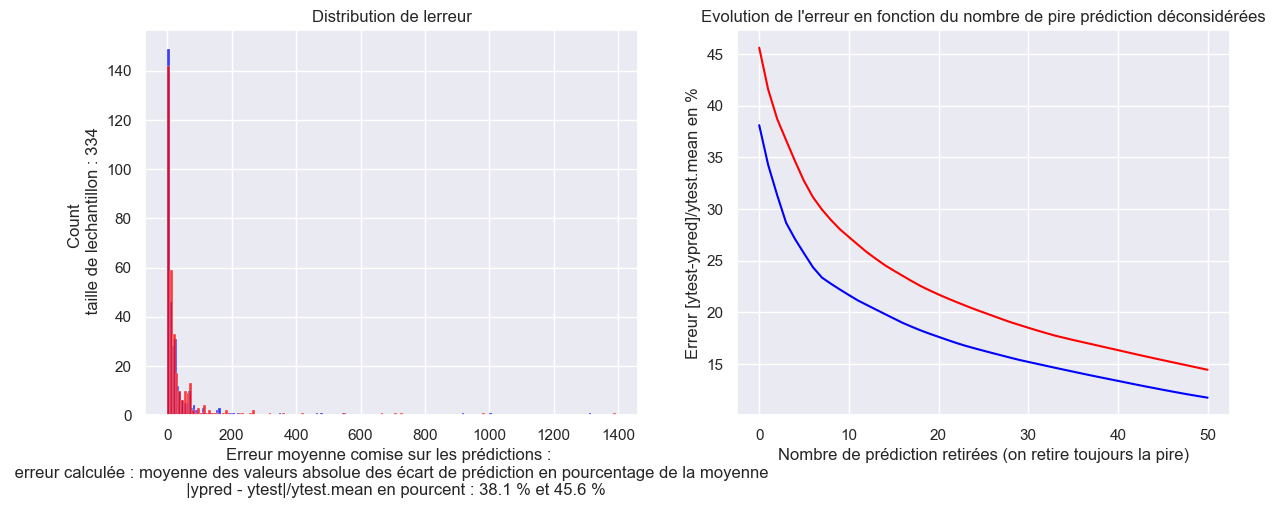

In [60]:
# Voyons maintenant l'importance de l'energyscore en le retirant tout simplement de notre modèle prédictif, et en testant notre 
# modèle qui fonctionnait avec celui ci : 

xtrain2 = xtrain.drop(columns = ['ENERGYSTARScore'], inplace = False)
xtest2 = xtest.drop(columns = ['ENERGYSTARScore'], inplace = False)

model = GradientBoostingRegressor(init = RandomForestRegressor(n_estimators=5000, criterion = 'absolute_error',
                                                 bootstrap = True, oob_score=True, max_features = 16,
                                                 min_samples_leaf = 2, min_samples_split = 5), 
                                                 n_estimators = 200,
                                                 loss='absolute_error',
                                                 learning_rate=0.1, 
                                                 criterion = 'absolute_error')
model.fit(centre_et_norme(xtrain),passagelog(ytrain,True))
y_pred_avec = model.predict(centre_et_norme(xtest))
model.fit(centre_et_norme(xtrain2),passagelog(ytrain,True))
y_pred_sans = model.predict(centre_et_norme(xtest2))


if ytest.shape != y_pred_avec.shape:
    y_pred_avec = y_pred_avec.reshape(y_pred_avec.shape[0],)
if ytest.shape != y_pred_sans.shape:
    y_pred_sans = y_pred_sans.reshape(y_pred_sans.shape[0],)
erreur_absolue_avec = (abs(passagelog(y_pred_avec,False)-ytest)*100/ytest.mean()).to_numpy()
erreur_1 = erreur_absolue_avec
erreur_absolue_sans = (abs(passagelog(y_pred_sans,False)-ytest)*100/ytest.mean()).to_numpy()
erreur_2 = erreur_absolue_sans

evolution_avec = []
evolution_sans = []
nb_valeur_virees = []
evolution_avec.append(erreur_absolue_avec.mean())
evolution_sans.append(erreur_absolue_sans.mean())
nb_valeur_virees.append(0)
for i in range(50):
    erreur_absolue_avec = np.delete(erreur_absolue_avec, erreur_absolue_avec.argmax())
    erreur_absolue_sans = np.delete(erreur_absolue_sans, erreur_absolue_sans.argmax())
    evolution_avec.append(erreur_absolue_avec.mean())
    evolution_sans.append(erreur_absolue_sans.mean())
    nb_valeur_virees.append(i+1)


fig, ax = plt.subplots(ncols=2,figsize=(14, 5))
plt.sca(ax[0])
sns.histplot(erreur_1, color = 'blue')
sns.histplot(erreur_2, color = 'red')
plt.title(f'Distribution de lerreur')
plt.xlabel(f'Erreur moyenne comise sur les prédictions : \n erreur calculée : moyenne des valeurs absolue des écart de prédiction en pourcentage de la moyenne \n  |ypred - ytest|/ytest.mean en pourcent : {round(erreur_1.mean(),2)} % et {round(erreur_2.mean(),2)} %')
plt.ylabel(f'Count \n taille de lechantillon : {ytest.shape[0]}')
plt.sca(ax[1])
sns.lineplot(x = nb_valeur_virees, y = evolution_avec, color = 'blue')
sns.lineplot(x = nb_valeur_virees, y = evolution_sans, color = 'red')
plt.title("Evolution de l'erreur en fonction du nombre de pire prédiction déconsidérées")
plt.xlabel("Nombre de prédiction retirées (on retire toujours la pire)")
plt.ylabel("Erreur [ytest-ypred]/ytest.mean en %")


0
Mean_all_datas                185.083448
Mean_test_sample              178.815841
Mean_predictions_of_sample    141.503426
Mae                            67.929260
Mse                         46676.486270
Mse_square_rooted             216.047417
R2_score                        0.787432

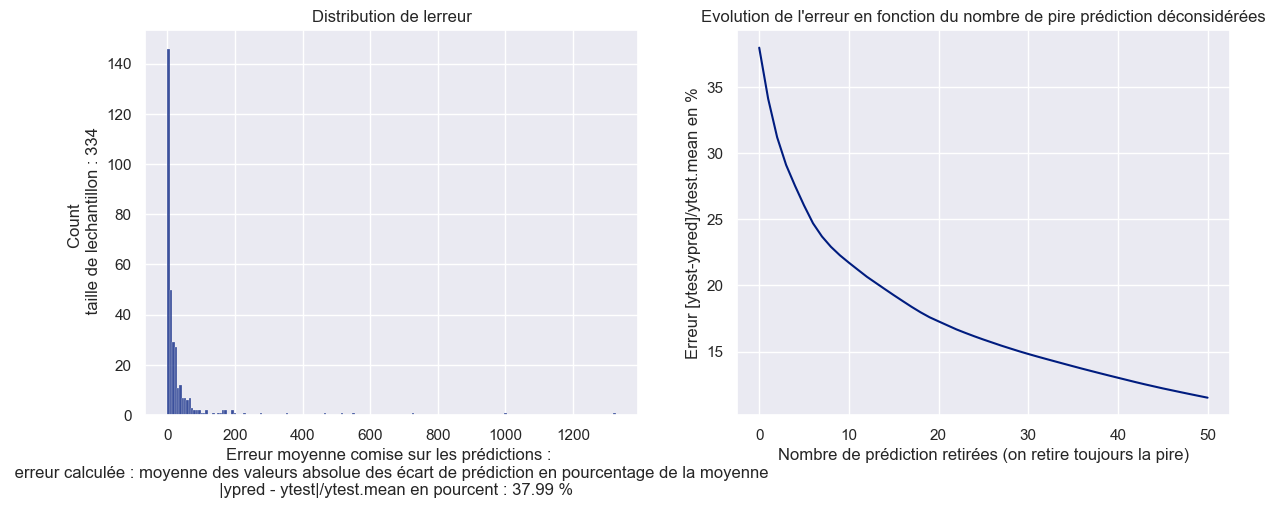

In [61]:
model = GradientBoostingRegressor(init = RandomForestRegressor(n_estimators=5000, criterion = 'absolute_error',
                                                 bootstrap = True, oob_score=True, max_features = 16,
                                                 min_samples_leaf = 2, min_samples_split = 5), 
                                                 n_estimators = 200,
                                                 loss='absolute_error',
                                                 learning_rate=0.1, 
                                                 criterion = 'absolute_error')
model.fit(centre_et_norme(xtrain),passagelog(ytrain,True))
y_pred = model.predict(centre_et_norme(xtest))

fig, ax = plt.subplots(ncols=2,figsize=(14, 5))
plt.sca(ax[0])
erreur_regression(ytest,y_pred,True)
plt.sca(ax[1])
evolution_erreur(ytest,y_pred,True)
ensembles_indicateur_qualite_prediction(ytest,y_pred, True)

0
Mean_all_datas                185.083448
Mean_test_sample              178.815841
Mean_predictions_of_sample    138.475090
Mae                            82.355658
Mse                         59863.342241
Mse_square_rooted             244.669864
R2_score                        0.727378

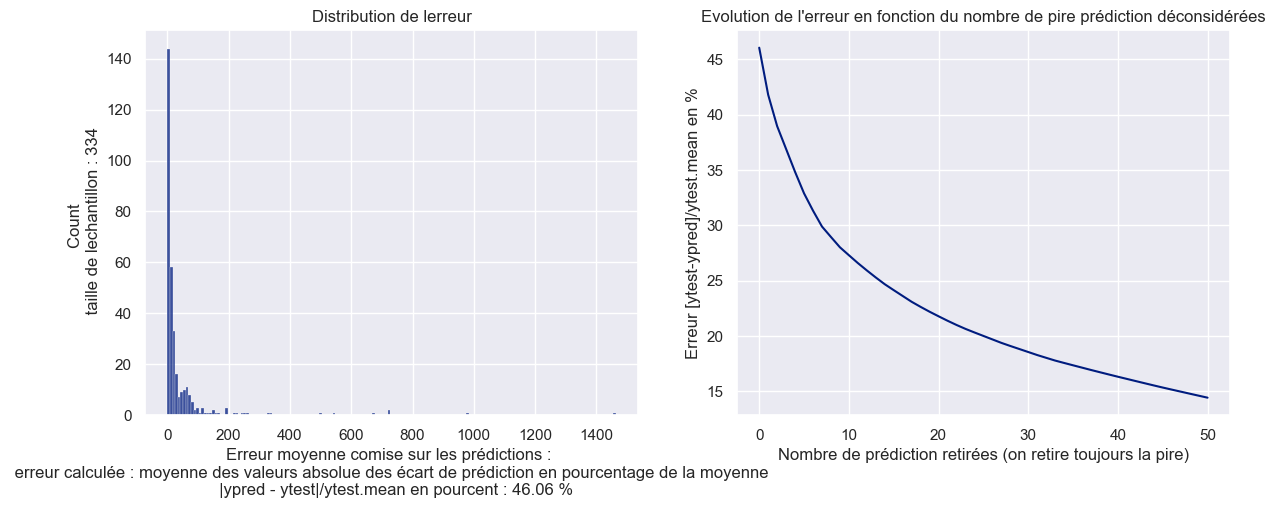

In [62]:
xtrain2 = xtrain.drop(columns = ['ENERGYSTARScore'], inplace = False)
xtest2 = xtest.drop(columns = ['ENERGYSTARScore'], inplace = False)

model2 = GradientBoostingRegressor(init = RandomForestRegressor(n_estimators=5000, criterion = 'absolute_error',
                                                 bootstrap = True, oob_score=True, max_features = 16,
                                                 min_samples_leaf = 2, min_samples_split = 5), 
                                                 n_estimators = 200,
                                                 loss='absolute_error',
                                                 learning_rate=0.1, 
                                                 criterion = 'absolute_error')
model2.fit(centre_et_norme(xtrain2),passagelog(ytrain,True))
y_pred2 = model2.predict(centre_et_norme(xtest2))


fig, ax = plt.subplots(ncols=2,figsize=(14, 5))
plt.sca(ax[0])
erreur_regression(ytest,y_pred2,True)
plt.sca(ax[1])
evolution_erreur(ytest,y_pred2,True)
ensembles_indicateur_qualite_prediction(ytest,y_pred2, True)

In [63]:
quality_avec_energy = ensembles_indicateur_qualite_prediction(ytest,y_pred, True)
quality_sans_energy = ensembles_indicateur_qualite_prediction(ytest,y_pred2, True)
quality = pd.merge(quality_avec_energy, quality_sans_energy, left_index=True, right_index=True)
quality.rename(columns = {quality.columns[0] : 'Avec_Escore', quality.columns[1] : 'Sans_Escore'}, inplace = True)
quality['Evolution_pourcent'] = (quality['Sans_Escore']-quality['Avec_Escore'])*100/quality['Avec_Escore']
quality

Avec_Escore   Sans_Escore  Evolution_pourcent
Mean_all_datas                185.083448    185.083448            0.000000
Mean_test_sample              178.815841    178.815841            0.000000
Mean_predictions_of_sample    141.503426    138.475090           -2.140115
Mae                            67.929260     82.355658           21.237385
Mse                         46676.486270  59863.342241           28.251604
Mse_square_rooted             216.047417    244.669864           13.248225
R2_score                        0.787432      0.727378           -7.626559

In [64]:
feature_importance = pd.DataFrame(data = model.feature_importances_, index = X.columns, columns = ['Feature_importance_avec_Escore'])
feature_importance2 = pd.DataFrame(data = model2.feature_importances_, index = xtrain2.columns, columns = ['Feature_importance_sans_Escore'])
features = pd.merge(feature_importance, feature_importance2, left_index=True, right_index=True, how = 'outer')
features.sort_values(by = 'Feature_importance_avec_Escore', ascending = False)

Feature_importance_avec_Escore  \
PropertyGFABuilding(s)                               0.214460   
YearBuilt                                            0.202169   
ENERGYSTARScore                                      0.179937   
proportion steam (en %)                              0.109715   
proportion gas (en %)                                0.103118   
NumberofFloors                                       0.059105   
GREATER DUWAMISH                                     0.028468   
proportion electricity (en %)                        0.027203   
EAST                                                 0.011839   
LAKE UNION                                           0.010393   
NumberofBuildings                                    0.009851   
NORTH                                                0.009218   
DOWNTOWN                                             0.008043   
MAGNOLIA / QUEEN ANNE                                0.005242   
NORTHEAST                                            0.004609   
NORTHWEST                                            0.003615   
DELRIDGE                                             0.003615   
BALLARD                                              0.003254   
SOUTHWEST                                            0.003254   
CENTRAL                                              0.002259   
SOUTHEAST                                            0.000362   
North                                                0.000181   
Northwest                                            0.000090   
Ballard                                              0.000000   
Delridge                                             0.000000   
DELRIDGE NEIGHBORHOODS                               0.000000   
Central                                              0.000000   

                               Feature_importance_sans_Escore  
PropertyGFABuilding(s)                               0.244258  
YearBuilt                                            0.218062  
ENERGYSTARScore                                           NaN  
proportion steam (en %)                              0.134928  
proportion gas (en %)                                0.112321  
NumberofFloors                                       0.097249  
GREATER DUWAMISH                                     0.013517  
proportion electricity (en %)                        0.019019  
EAST                                                 0.022608  
LAKE UNION                                           0.015670  
NumberofBuildings                                    0.022129  
NORTH                                                0.003469  
DOWNTOWN                                             0.015789  
MAGNOLIA / QUEEN ANNE                                0.011722  
NORTHEAST                                            0.007177  
NORTHWEST                                            0.000957  
DELRIDGE                                             0.016507  
BALLARD                                              0.005263  
SOUTHWEST                                            0.008373  
CENTRAL                                              0.014474  
SOUTHEAST                                            0.012440  
North                                                0.000598  
Northwest                                            0.000957  
Ballard                                              0.000000  
Delridge                                             0.001435  
DELRIDGE NEIGHBORHOODS                               0.000000  
Central                                              0.001077

In [65]:
features.sort_values(by = 'Feature_importance_sans_Escore', ascending = False)

Feature_importance_avec_Escore  \
PropertyGFABuilding(s)                               0.214460   
YearBuilt                                            0.202169   
proportion steam (en %)                              0.109715   
proportion gas (en %)                                0.103118   
NumberofFloors                                       0.059105   
EAST                                                 0.011839   
NumberofBuildings                                    0.009851   
proportion electricity (en %)                        0.027203   
DELRIDGE                                             0.003615   
DOWNTOWN                                             0.008043   
LAKE UNION                                           0.010393   
CENTRAL                                              0.002259   
GREATER DUWAMISH                                     0.028468   
SOUTHEAST                                            0.000362   
MAGNOLIA / QUEEN ANNE                                0.005242   
SOUTHWEST                                            0.003254   
NORTHEAST                                            0.004609   
BALLARD                                              0.003254   
NORTH                                                0.009218   
Delridge                                             0.000000   
Central                                              0.000000   
Northwest                                            0.000090   
NORTHWEST                                            0.003615   
North                                                0.000181   
Ballard                                              0.000000   
DELRIDGE NEIGHBORHOODS                               0.000000   
ENERGYSTARScore                                      0.179937   

                               Feature_importance_sans_Escore  
PropertyGFABuilding(s)                               0.244258  
YearBuilt                                            0.218062  
proportion steam (en %)                              0.134928  
proportion gas (en %)                                0.112321  
NumberofFloors                                       0.097249  
EAST                                                 0.022608  
NumberofBuildings                                    0.022129  
proportion electricity (en %)                        0.019019  
DELRIDGE                                             0.016507  
DOWNTOWN                                             0.015789  
LAKE UNION                                           0.015670  
CENTRAL                                              0.014474  
GREATER DUWAMISH                                     0.013517  
SOUTHEAST                                            0.012440  
MAGNOLIA / QUEEN ANNE                                0.011722  
SOUTHWEST                                            0.008373  
NORTHEAST                                            0.007177  
BALLARD                                              0.005263  
NORTH                                                0.003469  
Delridge                                             0.001435  
Central                                              0.001077  
Northwest                                            0.000957  
NORTHWEST                                            0.000957  
North                                                0.000598  
Ballard                                              0.000000  
DELRIDGE NEIGHBORHOODS                               0.000000  
ENERGYSTARScore                                           NaN

In [66]:
import shap

In [57]:
# Je n'ai pas trouvé d'explainer sur SHAP qui acceptait à la fois le gradient booster comme modèle et 
# la random forest en initialisation de celui ci. Je crée donc un nouveau modèle sans initialisation (ses performance sont très proche
# du modèle précédent) pour étudier les SHAP values.

background_data = shap.sample(xtrain2, nsamples=100)
explainer = shap.TreeExplainer(model2,background_data)


AssertionError: Unsupported init model type: <class 'sklearn.ensemble._forest.RandomForestRegressor'>

0
Mean_all_datas                 185.083448
Mean_test_sample               178.815841
Mean_predictions_of_sample     127.716871
Mae                             89.582082
Mse                         109909.334010
Mse_square_rooted              331.525767
R2_score                         0.499465

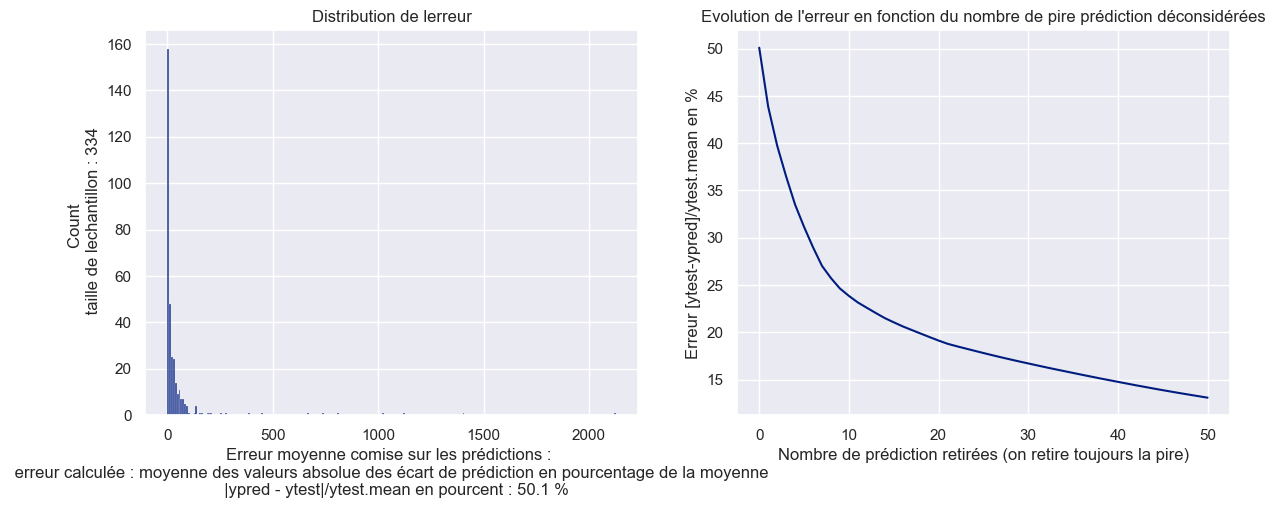

In [67]:
model = GradientBoostingRegressor(criterion = 'absolute_error', learning_rate = 0.2,
                                  loss = 'absolute_error', n_estimators = 100)
model.fit(centre_et_norme(xtrain),passagelog(ytrain,True))
y_pred = model.predict(centre_et_norme(xtest))


fig, ax = plt.subplots(ncols=2,figsize=(14, 5))
plt.sca(ax[0])
erreur_regression(ytest,y_pred,True)
plt.sca(ax[1])
evolution_erreur(ytest,y_pred,True)
ensembles_indicateur_qualite_prediction(ytest,y_pred, True)

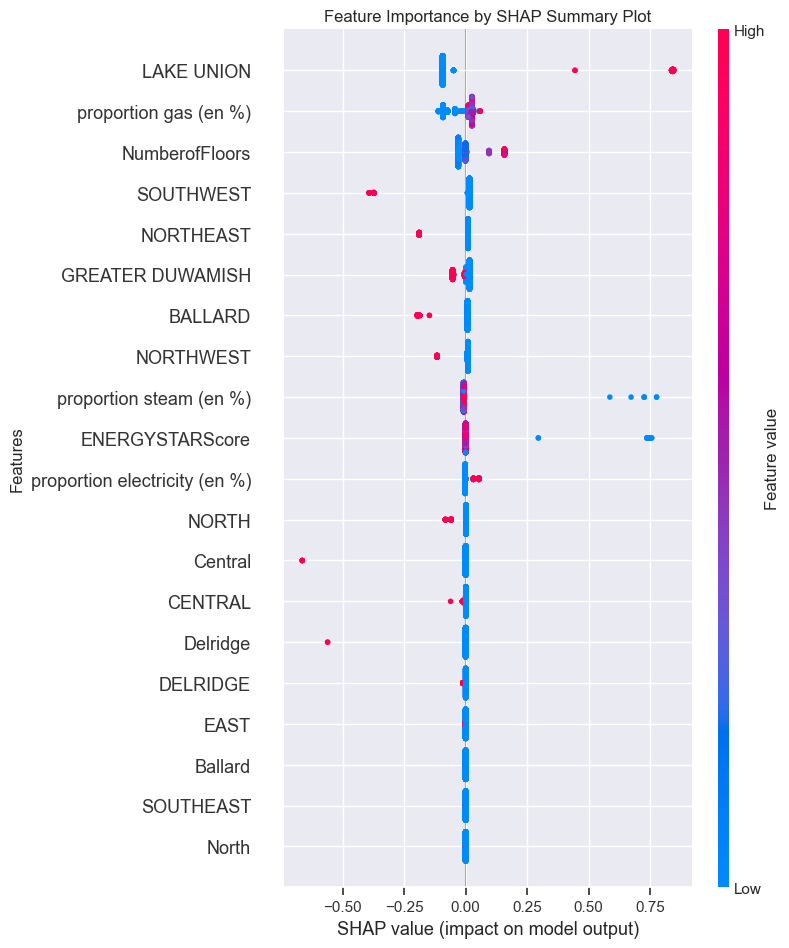

In [68]:
background_data = shap.sample(xtrain, nsamples=100)
explainer = shap.TreeExplainer(model,background_data)
shap_values = explainer.shap_values(xtrain)
shap.summary_plot(shap_values, xtrain, feature_names= xtrain.columns,
                 show=False)
plt.title("Feature Importance by SHAP Summary Plot")
plt.ylabel("Features")
plt.show()

0
Mean_all_datas                 185.083448
Mean_test_sample               178.815841
Mean_predictions_of_sample     129.720446
Mae                             94.729360
Mse                         102083.944350
Mse_square_rooted              319.505781
R2_score                         0.535102

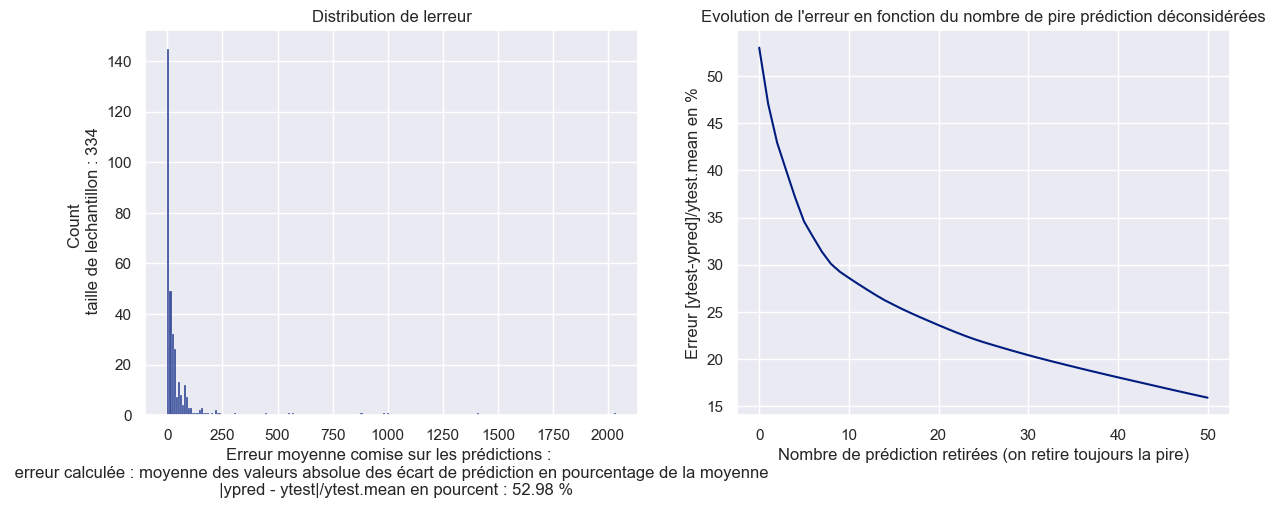

In [69]:
xtrain2 = xtrain.drop(columns = ['ENERGYSTARScore'], inplace = False)
xtest2 = xtest.drop(columns = ['ENERGYSTARScore'], inplace = False)

model3 = GradientBoostingRegressor(n_estimators = 200,
                                   loss='absolute_error',
                                   learning_rate=0.2, 
                                   criterion = 'absolute_error')
model3.fit(centre_et_norme(xtrain2),passagelog(ytrain,True))
y_pred2 = model3.predict(centre_et_norme(xtest2))


fig, ax = plt.subplots(ncols=2,figsize=(14, 5))
plt.sca(ax[0])
erreur_regression(ytest,y_pred2,True)
plt.sca(ax[1])
evolution_erreur(ytest,y_pred2,True)
ensembles_indicateur_qualite_prediction(ytest,y_pred2, True)

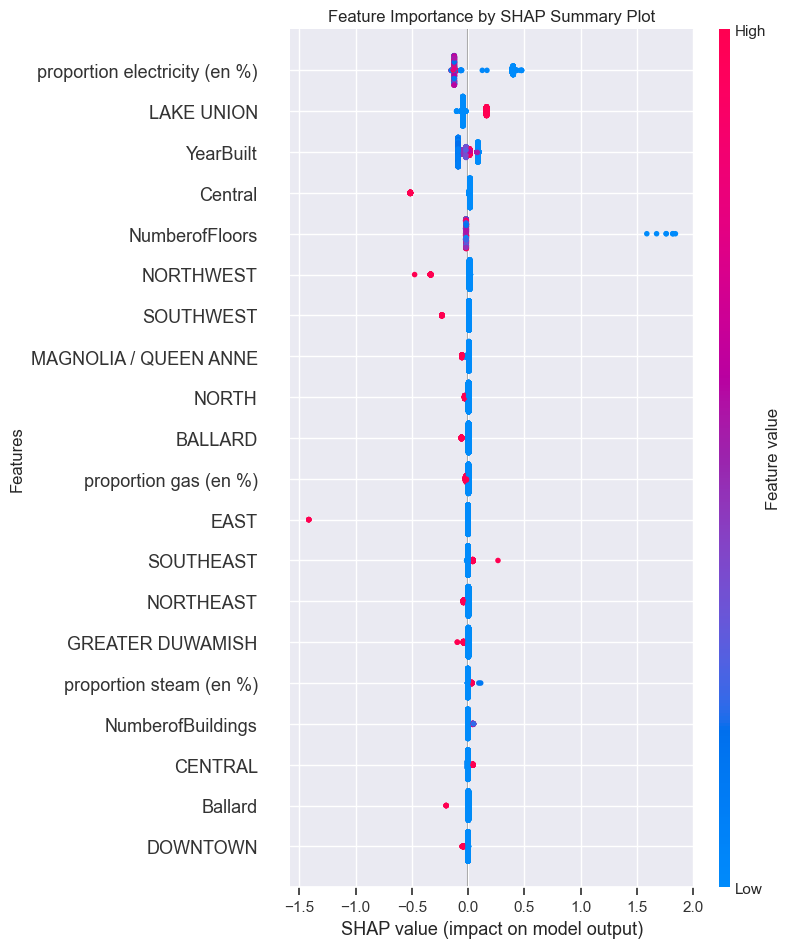

In [70]:
background_data = shap.sample(xtrain2, nsamples=100)
explainer = shap.TreeExplainer(model3,background_data)
shap_values = explainer.shap_values(xtrain2)
shap.summary_plot(shap_values, xtrain2, feature_names= xtrain.columns,
                 show=False)
plt.title("Feature Importance by SHAP Summary Plot")
plt.ylabel("Features")
plt.show()